In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexPE"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex_pe-xception-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = Xception(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 238s 26ms/step - loss: 0.8287 - acc: 0.7544 - val_loss: 2.9295 - val_acc: 0.5020
Epoch 2/100
9112/9112 [==============================] - 232s 25ms/step - loss: 0.4859 - acc: 0.8528 - val_loss: 1.6343 - val_acc: 0.7373
Epoch 3/100
9116/9116 [==============================] - 229s 25ms/step - loss: 0.0158 - acc: 0.9948 - val_loss: 0.4647 - val_acc: 0.9324
Epoch 84/100
9120/9120 [==============================] - 241s 26ms/step - loss: 0.0963 - acc: 0.9667 - val_loss: 0.6970 - val_acc: 0.8455
Epoch 27/100
9120/9120 [==============================] - 239s 26ms/step - loss: 0.1017 - acc: 0.9667 - val_loss: 2.6994 - val_acc: 0.6398
Epoch 28/100
9120/9120 [==============================] - 236s 26ms/step - loss: 0.0724 - acc: 0.9759 - val_loss: 0.4720 - val_acc: 0.9114
Epoch 29/100
9120/9120 [==============================] - 237s 26ms/step - loss: 0.0767 - acc: 0.9741 - val_loss: 0.4954 

9120/9120 [==============================] - 241s 26ms/step - loss: 0.0126 - acc: 0.9953 - val_loss: 0.6642 - val_acc: 0.9144
Epoch 82/100
9120/9120 [==============================] - 235s 26ms/step - loss: 0.0205 - acc: 0.9934 - val_loss: 0.8337 - val_acc: 0.8927
Epoch 83/100
9120/9120 [==============================] - 242s 27ms/step - loss: 0.0172 - acc: 0.9945 - val_loss: 0.6427 - val_acc: 0.9094
Epoch 84/100
9120/9120 [==============================] - 233s 26ms/step - loss: 0.0185 - acc: 0.9932 - val_loss: 0.7227 - val_acc: 0.9114
Epoch 85/100
9120/9120 [==============================] - 229s 25ms/step - loss: 0.0241 - acc: 0.9924 - val_loss: 0.6607 - val_acc: 0.9124
Epoch 86/100
9120/9120 [==============================] - 228s 25ms/step - loss: 0.0227 - acc: 0.9922 - val_loss: 0.8418 - val_acc: 0.8317
Epoch 87/100
9120/9120 [==============================] - 225s 25ms/step - loss: 0.0157 - acc: 0.9940 - val_loss: 0.6438 - val_acc: 0.9173
Epoch 88/100
9120/9120 [================

9120/9120 [==============================] - 248s 27ms/step - loss: 0.0377 - acc: 0.9884 - val_loss: 0.4514 - val_acc: 0.9331
Epoch 40/100
9120/9120 [==============================] - 242s 27ms/step - loss: 0.0333 - acc: 0.9902 - val_loss: 0.3290 - val_acc: 0.9439
Epoch 41/100
9120/9120 [==============================] - 246s 27ms/step - loss: 0.0264 - acc: 0.9911 - val_loss: 0.3873 - val_acc: 0.9350
Epoch 42/100
9120/9120 [==============================] - 241s 26ms/step - loss: 0.0291 - acc: 0.9910 - val_loss: 0.3747 - val_acc: 0.9311
Epoch 43/100
9120/9120 [==============================] - 241s 26ms/step - loss: 0.0393 - acc: 0.9877 - val_loss: 0.5094 - val_acc: 0.9173
Epoch 44/100
9120/9120 [==============================] - 242s 27ms/step - loss: 0.0209 - acc: 0.9942 - val_loss: 0.3647 - val_acc: 0.9409
Epoch 45/100
9120/9120 [==============================] - 237s 26ms/step - loss: 0.0336 - acc: 0.9886 - val_loss: 0.4501 - val_acc: 0.9203
Epoch 46/100
9120/9120 [================

9127/9127 [==============================] - 241s 26ms/step - loss: 0.0065 - acc: 0.9977 - val_loss: 0.5107 - val_acc: 0.9316
Epoch 82/100
9127/9127 [==============================] - 246s 27ms/step - loss: 0.0315 - acc: 0.9915 - val_loss: 0.5124 - val_acc: 0.9257
Epoch 83/100
9127/9127 [==============================] - 245s 27ms/step - loss: 0.0081 - acc: 0.9974 - val_loss: 0.4895 - val_acc: 0.9316
Epoch 84/100
9127/9127 [==============================] - 239s 26ms/step - loss: 0.0048 - acc: 0.9981 - val_loss: 0.4749 - val_acc: 0.9316
Epoch 85/100
9127/9127 [==============================] - 244s 27ms/step - loss: 0.0105 - acc: 0.9967 - val_loss: 0.4523 - val_acc: 0.9356
Epoch 86/100
9127/9127 [==============================] - 236s 26ms/step - loss: 0.0270 - acc: 0.9920 - val_loss: 0.4912 - val_acc: 0.9237
Epoch 87/100
9127/9127 [==============================] - 243s 27ms/step - loss: 0.0169 - acc: 0.9953 - val_loss: 0.4473 - val_acc: 0.9366
Epoch 88/100
9127/9127 [================

Epoch 43/100
9132/9132 [==============================] - 129s 14ms/step - loss: 0.0264 - acc: 0.9912 - val_loss: 0.3273 - val_acc: 0.9472
Epoch 44/100
9132/9132 [==============================] - 129s 14ms/step - loss: 0.0303 - acc: 0.9906 - val_loss: 0.3693 - val_acc: 0.9363
Epoch 45/100
9132/9132 [==============================] - 130s 14ms/step - loss: 0.0193 - acc: 0.9934 - val_loss: 0.3430 - val_acc: 0.9373
Epoch 46/100
9132/9132 [==============================] - 132s 14ms/step - loss: 0.0169 - acc: 0.9947 - val_loss: 0.3651 - val_acc: 0.9382
Epoch 47/100
9132/9132 [==============================] - 133s 15ms/step - loss: 0.0382 - acc: 0.9894 - val_loss: 0.4853 - val_acc: 0.9273
Epoch 48/100
9132/9132 [==============================] - 133s 15ms/step - loss: 0.0349 - acc: 0.9885 - val_loss: 0.3353 - val_acc: 0.9432
Epoch 49/100
9132/9132 [==============================] - 132s 14ms/step - loss: 0.0406 - acc: 0.9869 - val_loss: 0.3398 - val_acc: 0.9432
Epoch 50/100
9132/9132 [===

In [ ]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9359


In [ ]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

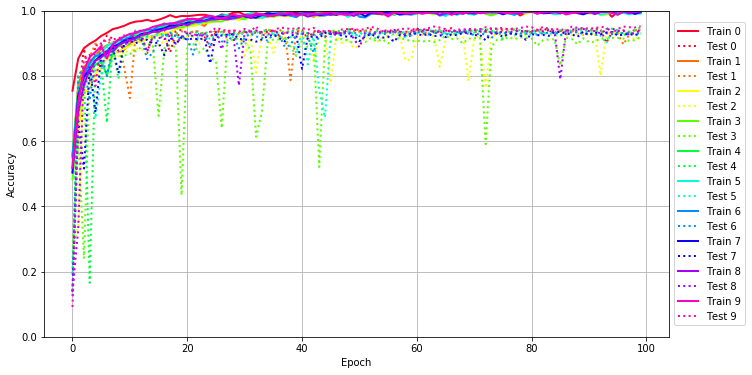

In [ ]:
plot_acc(history)

In [ ]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

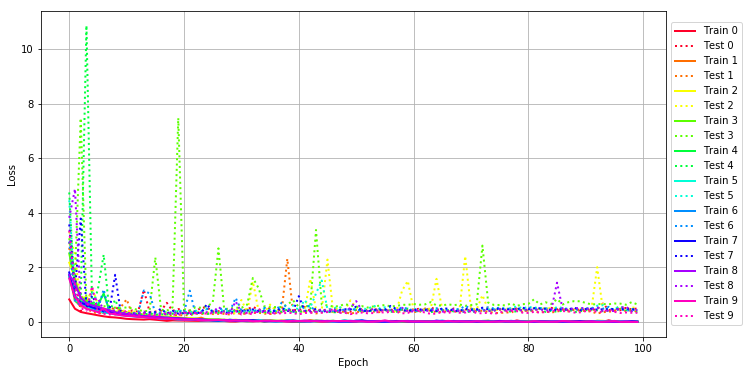

In [ ]:
plot_loss(history)

Plotting the confusion matrix


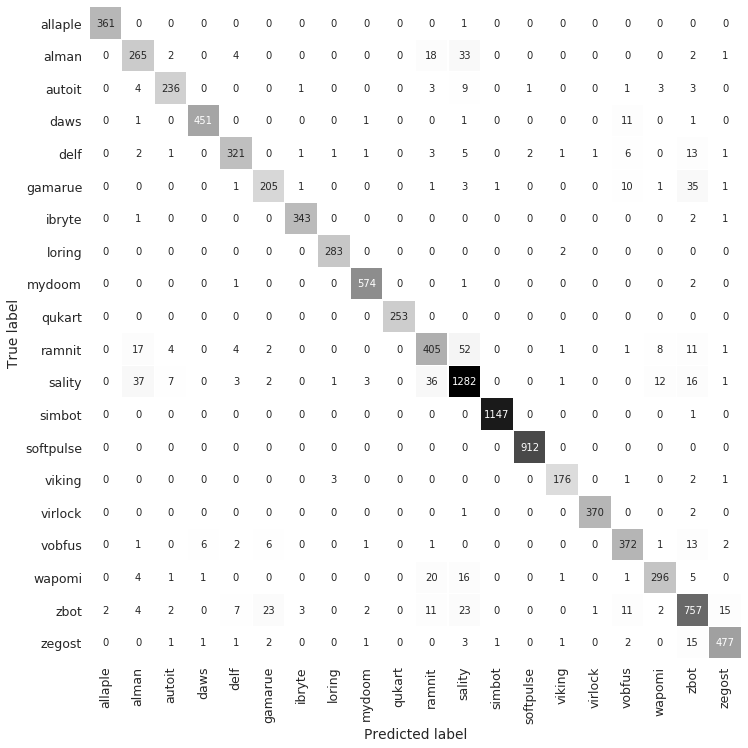

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


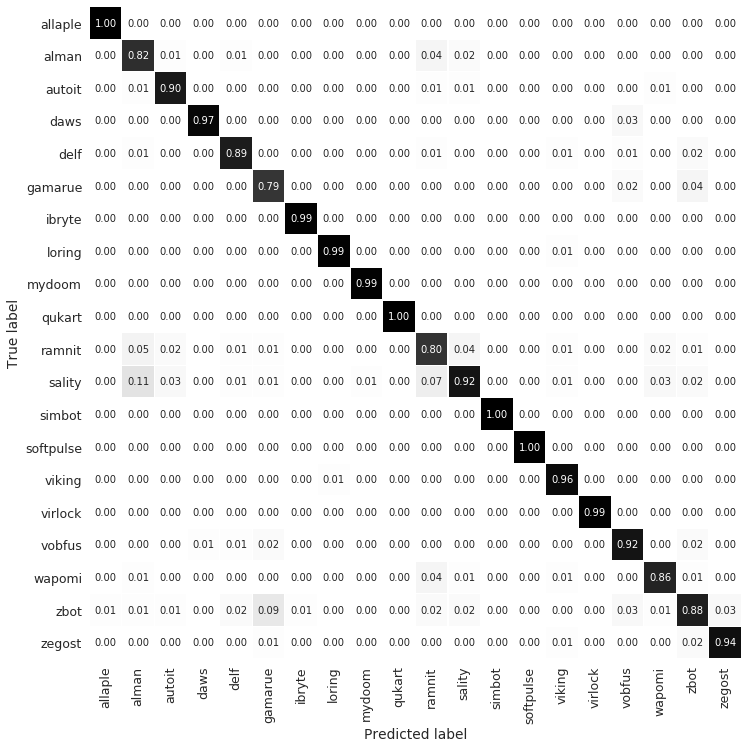

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
for h in history:
    print(h.history)

{'val_loss': [2.9295195583745226, 1.6343405796291544, 0.4038811941596312, 0.8924050980822611, 0.39245678032278875, 0.4775581590567981, 0.3258345967475833, 0.39251656695672654, 0.5621947553457858, 0.41120808296363975, 0.3556700531454595, 0.4268358024805501, 0.37431604348396563, 1.1810195805055637, 0.3690963985230913, 0.3833106853845192, 0.41242350629403335, 0.7044233360549867, 0.40993249964612577, 0.47474504554446506, 0.43610351599460984, 0.41185177374251225, 0.3835792451110236, 0.5287559482358875, 0.5298705453359993, 0.38699882593016754, 0.39811152386901805, 0.38431596472665364, 0.4116759312020055, 0.4320320797868633, 0.39888243908116383, 0.4771850905387618, 0.547886091261184, 0.47038832891214355, 0.39001786169268593, 0.517067717403624, 0.47367508080992904, 0.41448078051870496, 0.43222181008222105, 0.44838703236036626, 0.43123499199736237, 0.5562450832577452, 0.4112593848260202, 0.44075480385152144, 0.43160085453491437, 0.4536703399461901, 0.500986709801369, 0.4582495220058398, 0.40100

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

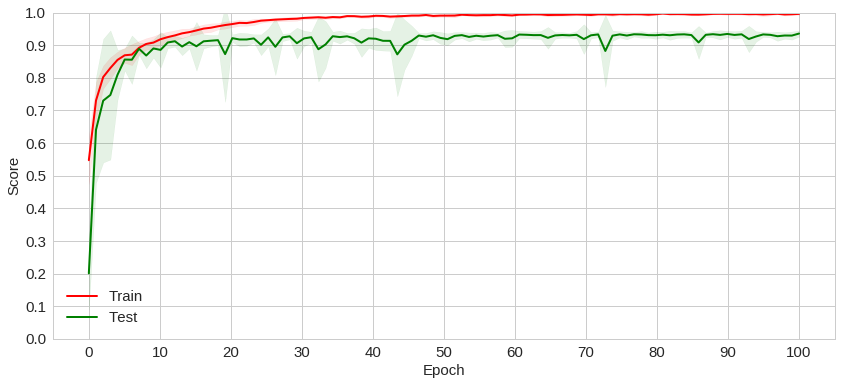

In [ ]:
plot_mean_acc(history)

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

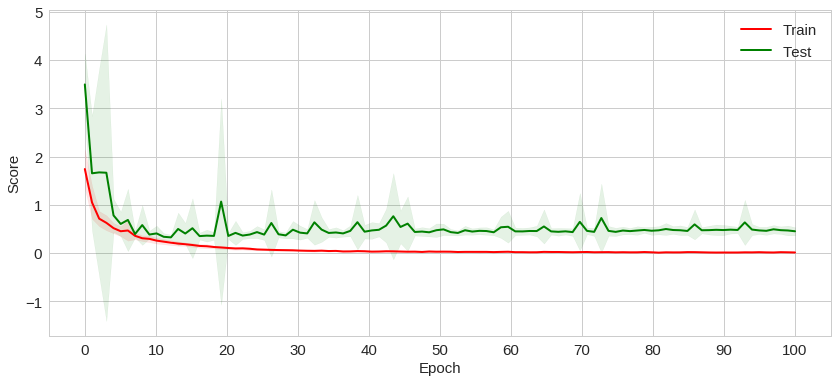

In [ ]:
plot_mean_loss(history)

In [2]:
hist = [{'val_loss': [2.9295195583745226, 1.6343405796291544, 0.4038811941596312, 0.8924050980822611, 0.39245678032278875, 0.4775581590567981, 0.3258345967475833, 0.39251656695672654, 0.5621947553457858, 0.41120808296363975, 0.3556700531454595, 0.4268358024805501, 0.37431604348396563, 1.1810195805055637, 0.3690963985230913, 0.3833106853845192, 0.41242350629403335, 0.7044233360549867, 0.40993249964612577, 0.47474504554446506, 0.43610351599460984, 0.41185177374251225, 0.3835792451110236, 0.5287559482358875, 0.5298705453359993, 0.38699882593016754, 0.39811152386901805, 0.38431596472665364, 0.4116759312020055, 0.4320320797868633, 0.39888243908116383, 0.4771850905387618, 0.547886091261184, 0.47038832891214355, 0.39001786169268593, 0.517067717403624, 0.47367508080992904, 0.41448078051870496, 0.43222181008222105, 0.44838703236036626, 0.43123499199736237, 0.5562450832577452, 0.4112593848260202, 0.44075480385152144, 0.43160085453491437, 0.4536703399461901, 0.500986709801369, 0.4582495220058398, 0.401006784571702, 0.37881959607586646, 0.44148228998686, 0.4688725833956391, 0.4272985508535654, 0.5039277939952767, 0.42006255946994253, 0.4185640146257281, 0.45619470442519594, 0.41542093951429493, 0.456363399135125, 0.4304010855019511, 0.46199171643225556, 0.48445849185455847, 0.4199812989348257, 0.5264769226130186, 0.4624235432894057, 0.4476645150943921, 0.4025642129231439, 0.4986010149372757, 0.4274542005011521, 0.4240166812032049, 0.4562440937721908, 0.47077806941039313, 0.4105014454191176, 0.4459328414297232, 0.44656614531943273, 0.45452698449114237, 0.4284085763058707, 0.48565879271362267, 0.5089686111857379, 0.41103597174152284, 0.4174040453148531, 0.4427167139290695, 0.4837879320473446, 0.47854306260999957, 0.5189471007752333, 0.46583048804413485, 0.46296974895677945, 0.4329349489872616, 0.46229238528084693, 0.44965997737166896, 0.4559741540698994, 0.4495593220259586, 0.4624444373211114, 0.6781881652431037, 0.44570750081578714, 0.42175408129497205, 0.42853811824995436, 0.5185157738449377, 0.4652203011936269, 0.49995389174719396], 'val_acc': [0.501953125, 0.7373046875, 0.8837890625, 0.7822265625, 0.89453125, 0.8916015625, 0.923828125, 0.9140625, 0.8671875, 0.9150390625, 0.9267578125, 0.9091796875, 0.9287109375, 0.869140625, 0.935546875, 0.9326171875, 0.9228515625, 0.8720703125, 0.9296875, 0.9189453125, 0.919921875, 0.9375, 0.935546875, 0.9208984375, 0.8857421875, 0.9365234375, 0.9345703125, 0.9384765625, 0.93359375, 0.9326171875, 0.935546875, 0.935546875, 0.931640625, 0.9306640625, 0.93359375, 0.94140625, 0.9228515625, 0.931640625, 0.939453125, 0.9345703125, 0.9404296875, 0.912109375, 0.9375, 0.9345703125, 0.9345703125, 0.9365234375, 0.9345703125, 0.9296875, 0.9423828125, 0.9423828125, 0.9375, 0.9384765625, 0.9423828125, 0.931640625, 0.9375, 0.9404296875, 0.9375, 0.9345703125, 0.9345703125, 0.9384765625, 0.9423828125, 0.9345703125, 0.9423828125, 0.931640625, 0.9326171875, 0.9375, 0.9462890625, 0.93359375, 0.94140625, 0.9384765625, 0.9375, 0.9423828125, 0.9404296875, 0.9443359375, 0.943359375, 0.9423828125, 0.943359375, 0.9453125, 0.9287109375, 0.9375, 0.93359375, 0.9384765625, 0.9453125, 0.9384765625, 0.9326171875, 0.9375, 0.9375, 0.9345703125, 0.9384765625, 0.9453125, 0.9404296875, 0.943359375, 0.943359375, 0.9013671875, 0.93359375, 0.9345703125, 0.939453125, 0.9345703125, 0.9404296875, 0.9384765625], 'loss': [0.8287202208789427, 0.48585963898106976, 0.36871256089922205, 0.32358336945810895, 0.28595566574919107, 0.2462561230769641, 0.20932932129036552, 0.18012097337601266, 0.1668512621817618, 0.14502872152808363, 0.11594907292945734, 0.10416718229121603, 0.09569769370254322, 0.08811072537228236, 0.10356366800968524, 0.08463109914815221, 0.06527091603631299, 0.041678403907200394, 0.05951908279892672, 0.05437563634560345, 0.051993839636517, 0.04634390896727119, 0.043040389459190975, 0.040570728971875955, 0.05387408489267782, 0.06462390907967334, 0.039168204739362764, 0.03887015464465249, 0.020687697002107888, 0.017476954407658007, 0.04086704035272721, 0.025868605658382542, 0.027530639333484076, 0.044439532182852334, 0.021431243076720282, 0.03740731043936529, 0.031006531883087343, 0.03439608649129166, 0.02236964947370182, 0.013819118889986303, 0.00872753999988542, 0.018937830600737903, 0.054590168735937396, 0.02753547799081666, 0.014499111305671605, 0.008061609300098693, 0.015748238032381193, 0.025526484322012943, 0.05307248521703921, 0.018902866173975286, 0.013085726177465224, 0.020516728789291314, 0.02886850229344683, 0.02367700008937416, 0.014971823657898257, 0.011311560539067947, 0.02590799466965272, 0.015810155867430255, 0.01121617095787283, 0.01436791199386735, 0.008887991868376638, 0.023304922990006877, 0.011436170629240926, 0.006908593937671574, 0.03017119218091592, 0.012271597045891914, 0.0177885632239452, 0.015023573167124929, 0.010925875332794594, 0.017227348060127278, 0.017731498582953233, 0.02165344069181837, 0.014837298587251966, 0.006831949415395608, 0.002546904778847293, 0.00361620223584771, 0.005327947123071659, 0.005370109565535975, 0.05773341808340899, 0.018331281595437295, 0.007276470265465518, 0.003943744722359245, 0.004085058424060294, 0.006343337213874531, 0.033317411753370635, 0.020553322030851556, 0.007910293691793613, 0.005172056774984247, 0.0029319232566012384, 0.005419582108133414, 0.0024848718139046317, 0.001979660612078541, 0.0015886191862536962, 0.005077668795614886, 0.06393556149562327, 0.011116605928474377, 0.007163395450202611, 0.01131420358215876, 0.005863616927104515, 0.004500410840025801], 'acc': [0.754389815732405, 0.8528314311322254, 0.8849868305531168, 0.8982660229317027, 0.908362598875513, 0.9225197542226555, 0.9318481124839414, 0.9432616330114135, 0.9476514486914879, 0.9533582090598852, 0.9614793678665496, 0.9664179105000918, 0.9679543460221328, 0.9716856892010536, 0.9672958736779713, 0.9721246708684893, 0.978270412642669, 0.9860623354865753, 0.979697102826347, 0.983647936786655, 0.983099209833187, 0.9849648814749781, 0.9870500438981563, 0.987379280070237, 0.9835381915006227, 0.9796971027216856, 0.9881474979097535, 0.9862818262679625, 0.9935250219490781, 0.9952809482001755, 0.9869402985074627, 0.9908911326770933, 0.9920983318700615, 0.9854038630377524, 0.9938542581211589, 0.987928007023705, 0.990342405618964, 0.9895741878841089, 0.9924275680421423, 0.9958296751536435, 0.9970368744512731, 0.9934152765583846, 0.982550482879719, 0.9908911326770933, 0.9955004389815628, 0.9971466198419666, 0.994622475856014, 0.99231782275611, 0.983977173063397, 0.992756804214223, 0.9959394205443372, 0.9942932396839332, 0.9930860403863038, 0.9928665496049166, 0.9952809482001755, 0.9964881474978051, 0.9928665496049166, 0.9944029851792883, 0.9956101843722563, 0.9949517120280948, 0.9972563652326603, 0.9930860404909652, 0.99571992976295, 0.9978050921861282, 0.9919885864793678, 0.9956101843722563, 0.9936347673397717, 0.9957199298676113, 0.9960491659350307, 0.9955004389815628, 0.9950614574187884, 0.9936347673397717, 0.9952809482001755, 0.9982440737489026, 0.9992317822651449, 0.9987928007023705, 0.9984635645302897, 0.9983538191395961, 0.9850746268656716, 0.9938542581211589, 0.997585601404741, 0.9984635645302897, 0.9982440737489026, 0.9980245829675154, 0.9900131694992139, 0.9930860403863038, 0.9970368744512731, 0.9980245829675154, 0.9985733099209834, 0.9984635645302897, 0.9989025460930641, 0.9990122914837577, 0.9992317822651449, 0.9985733099209834, 0.9811237928007024, 0.9960491659350307, 0.9974758560140474, 0.996268656716418, 0.9984635645302897, 0.9984635645302897]},
{'val_loss': [2.7177158554472802, 1.140254460639683, 1.0473354549407814, 0.5201660380033519, 0.3522623349361608, 0.3283072116755941, 0.33833717657781687, 0.3413080427592657, 0.2903427488788873, 0.5457668780930601, 0.8317374121757705, 0.2751005106368624, 0.28352706918704823, 0.26024201036022077, 0.31601447885231637, 0.22917846391303828, 0.33047139224326255, 0.2607184943378606, 0.2468243656410265, 0.25184251735461377, 0.24617957340648264, 0.24920660950288384, 0.30487647915716914, 0.2962451482189783, 0.2995521315298756, 0.29077876520807355, 0.2986567220448869, 0.30066395339989477, 0.274718869477433, 0.33837797796026003, 0.29499747025013306, 0.31000732422396643, 0.3276169251206224, 0.34106812047636076, 0.30653663408914483, 0.2932816693080903, 0.33191125593771353, 0.3552995339560257, 2.31781814800205, 0.3488059639761405, 0.3649060957057607, 0.42055701359149483, 0.36739075486238953, 0.3144894451100588, 0.35072764793787664, 0.3766938898860931, 0.3683013378121926, 0.37035501394137904, 0.3800687117481662, 0.2936259314436833, 0.370758597789803, 0.37148815815378267, 0.4017122669781385, 0.38101917249305284, 0.3586533809549682, 0.4613130391743668, 0.408277075333973, 0.3688058488859512, 0.38797023754997045, 0.3887932932789827, 0.3751216243862239, 0.35852250885793596, 0.4973194621148208, 0.39814245038895835, 0.3662697207401801, 0.3763397852977298, 0.40260854843335325, 0.38453809640154696, 0.3798798852213193, 0.4429654829026991, 0.49787778131436816, 0.40112416529918643, 0.41293263001778013, 0.37725411714372453, 0.3397021507487481, 0.32444538920716476, 0.35509388727468527, 0.340577957881309, 0.46090289563000486, 0.3684954776509494, 0.42970149334773217, 0.3922438184903643, 0.3491570925434924, 0.3811366964592123, 0.3520390285667687, 0.378864014724956, 0.447950166999095, 0.38498702460174616, 0.44799610938714957, 0.41550447170446064, 0.40365057649573505, 0.38114535254650656, 0.31092579429840067, 0.36011225541169095, 0.37802514751480265, 0.3993065765988851, 0.4865826328085042, 0.40064298445613594, 0.42460566563823054, 0.3790840355002839], 'val_acc': [0.1898238747553816, 0.7142857142857143, 0.751467711304965, 0.8581213316572156, 0.8982387494201063, 0.8982387484869612, 0.909980432394666, 0.8904109589041096, 0.9119373776908023, 0.826810177291676, 0.7318982407304871, 0.9246575342465754, 0.9041095890410958, 0.9197651663405088, 0.9148727984344422, 0.9363992172211351, 0.9178082191780822, 0.9285714285714286, 0.929549903085787, 0.9363992172211351, 0.9324853228962818, 0.9354207436399217, 0.9363992181542802, 0.9285714285714286, 0.9187866936924406, 0.9422700587084148, 0.9354207436399217, 0.9334637964774951, 0.9393346379647749, 0.9256360087609338, 0.9363992172211351, 0.9275929549902152, 0.9373776908023483, 0.9324853228962818, 0.9442270058708415, 0.9354207436399217, 0.9412915851272016, 0.9334637964774951, 0.786692759295499, 0.9412915851272016, 0.9344422700587084, 0.9305283757338552, 0.9324853228962818, 0.9354207445730669, 0.9324853228962818, 0.9295499021526419, 0.9393346379647749, 0.9295499021526419, 0.9344422709918535, 0.9373776908023483, 0.9354207436399217, 0.9363992172211351, 0.9354207436399217, 0.9334637964774951, 0.9354207436399217, 0.9295499021526419, 0.9363992172211351, 0.9295499021526419, 0.9305283757338552, 0.9344422700587084, 0.9412915851272016, 0.9393346379647749, 0.9256360078277887, 0.9354207436399217, 0.94227005964156, 0.9442270058708415, 0.9354207436399217, 0.9363992172211351, 0.9334637964774951, 0.9344422700587084, 0.9334637964774951, 0.9354207436399217, 0.9344422700587084, 0.9363992172211351, 0.9354207436399217, 0.9393346379647749, 0.9412915851272016, 0.9422700587084148, 0.9324853228962818, 0.9393346379647749, 0.9334637964774951, 0.9393346379647749, 0.9383561643835616, 0.9393346379647749, 0.9383561643835616, 0.9383561643835616, 0.9305283776001454, 0.9393346379647749, 0.9295499021526419, 0.9266144814090019, 0.9412915851272016, 0.9363992172211351, 0.9354207436399217, 0.9334637964774951, 0.9324853228962818, 0.9295499021526419, 0.8962818017911072, 0.9266144814090019, 0.9393346379647749, 0.9412915851272016], 'loss': [1.6952244093838245, 0.7964130639375917, 0.5725409716452741, 0.5458485476798542, 0.47201090509598, 0.38268040842933565, 0.3470403595872686, 0.36961320237499173, 0.28233728513353773, 0.40738372448795007, 0.3333744707600914, 0.2889554681146461, 0.23854903881686387, 0.20411702500366447, 0.18756511571024342, 0.184586043157532, 0.17047761490542768, 0.1433291473222166, 0.11953561999016564, 0.1271359537100096, 0.11670794971540671, 0.10981627767351745, 0.11801546397673109, 0.15869199723129554, 0.07955286233010053, 0.0671541217595195, 0.06993385633837537, 0.05885961980472891, 0.0824053102633361, 0.06557512822458167, 0.058314803286745986, 0.04369603505109584, 0.04248317982040923, 0.04910805303397404, 0.05222622062688023, 0.049597495372023126, 0.0394786717141256, 0.05291486222056612, 0.042911946206627055, 0.03311328076135587, 0.037012762938662284, 0.0413085020143994, 0.06273580588799298, 0.027734750337548846, 0.02384320076398465, 0.029094266737607916, 0.027880060912202083, 0.030650751791332004, 0.03852245090010218, 0.02078995425065318, 0.02331034137565125, 0.021331637198501324, 0.03224902400782298, 0.035755519901668184, 0.03394528174048769, 0.01778791448284212, 0.04071468975897106, 0.02659098708877266, 0.02309368764834927, 0.02155082877832147, 0.016793407853391833, 0.029071359263903373, 0.014586740110919138, 0.02577337487532279, 0.022195524394392416, 0.02294406320272099, 0.025928490552605703, 0.014141470600511827, 0.014013178045941129, 0.023053793531228085, 0.021949254477771424, 0.022116468683949335, 0.026137735301486466, 0.04215024679482093, 0.022669191064817035, 0.015843509112239813, 0.00864336739522757, 0.005846716723258596, 0.018001421098711348, 0.025436106286496916, 0.011869800396611849, 0.02021595420108322, 0.016403640999507474, 0.0179247560465401, 0.01834192102807064, 0.01203629638184027, 0.021380369698295452, 0.01564017337935349, 0.012460134725517564, 0.020546245372439095, 0.012549040422285176, 0.013188402385047796, 0.007127111588117909, 0.005277589621407176, 0.015277731643196412, 0.013821754566820317, 0.017527757005969945, 0.032377051362133855, 0.015173073545685005, 0.00951423110784044], 'acc': [0.5481676541584376, 0.771560237128823, 0.8281764319938658, 0.8418915954655347, 0.8635066932875362, 0.8824884795504284, 0.8936800527577864, 0.8997147246910758, 0.9110160194025088, 0.8797454467488403, 0.8998244459989538, 0.9075049376419717, 0.926377002596986, 0.9351547071487464, 0.9376782972168604, 0.9408602150537635, 0.9438226904580278, 0.9522712310730744, 0.9583059031110023, 0.9577572965585325, 0.9615975424258207, 0.9646697388632872, 0.9609392145785528, 0.9529295591034596, 0.973996050124475, 0.9793723943020551, 0.9772876892692561, 0.9816765415843757, 0.9746543779717429, 0.978055738424402, 0.9805793285055958, 0.9873820495940312, 0.9873820495940312, 0.9844195742813254, 0.9838709677419355, 0.9851876234364714, 0.9862848366068099, 0.9836515251261795, 0.9854070661437859, 0.988369541364933, 0.9870528857619558, 0.9877112135176651, 0.9811279350449857, 0.9911125740618828, 0.9933070002194426, 0.9900153609831029, 0.9897959184589056, 0.9899056396752249, 0.9858459513752978, 0.9944042133897811, 0.9923195084485407, 0.9935264428351986, 0.9910028528455634, 0.9895764757515909, 0.9890278693037596, 0.9949528198376124, 0.9870528857619558, 0.9915514592933948, 0.9929778362958086, 0.9931972789115646, 0.9946236559139785, 0.9910028527540048, 0.994623656005537, 0.9914417379855168, 0.9918806232170287, 0.9926486723721747, 0.9923195084485407, 0.9958305903006364, 0.9955014263770025, 0.9927583937716112, 0.9921000658327848, 0.9930875576036866, 0.9924292297564187, 0.9865042792225658, 0.9934167215273206, 0.9953917050691244, 0.9973666886109283, 0.9980250164581962, 0.9946236559139785, 0.9924292297564187, 0.9961597542242704, 0.9944042133897811, 0.9948430985297345, 0.9937458854509545, 0.9944042132982225, 0.9951722624533684, 0.9933070002194426, 0.9948430985297345, 0.9963791968400263, 0.9938556067588326, 0.9957208689927584, 0.9960500329163924, 0.9976958525345622, 0.9983541803818301, 0.9962694755321484, 0.9957208689927584, 0.9940750493745886, 0.9906736888303709, 0.9957208689927584, 0.9970375246872942]},
{'val_loss': [3.319156385870541, 2.440279669855155, 0.7202826524043784, 0.6937038420973455, 1.2455047737222675, 0.6577700543126055, 0.47592892262162456, 0.4950459745881602, 0.4301509783091937, 0.4227159891739789, 0.4065006641625408, 0.3879313248318866, 0.37025550640936866, 0.38306638471480897, 0.3455337886269405, 0.35814505197180835, 0.3298690908366481, 0.35301725999503175, 0.33775511402671005, 0.3548296899387709, 0.3310596254134925, 0.33781639687076676, 0.3791925513402698, 0.35152770703265845, 0.35253861861556823, 0.32216438674267384, 0.3390807343123586, 0.36580271792610053, 0.36318739241167297, 0.31109332366035874, 0.8084695571522317, 0.37641820437549683, 1.4853294862673447, 0.39989035813498547, 0.3423384359932742, 0.6409118037503659, 0.4217691644841847, 0.4496353490243528, 0.4144868373728759, 0.37738607590150675, 0.4414750702937632, 0.3665757648356676, 1.5831028246046879, 0.465185264778027, 0.43091774379766623, 2.2875551958448055, 0.3561712089300361, 0.5713776133384075, 0.42650825658021424, 0.7936672909194773, 0.5329629051568806, 0.4114231490029352, 0.3903163358615752, 0.5973667452111867, 0.43946153659352977, 0.4373076333905775, 0.421882989143058, 0.3913988686524804, 1.1501643836590458, 1.5056593760698438, 0.4503195167535728, 0.4332560278455044, 0.4562334672437917, 0.4931126562469908, 1.583678048393531, 0.44667579127769974, 0.4362112787479106, 0.4394124073526882, 0.4308388868162593, 2.4171236357412402, 0.49708675181387285, 0.4608106824227786, 0.9852587340800228, 0.4634074355488052, 0.44093309429684124, 0.4513185997098376, 0.48935334700306743, 0.4812122762922342, 0.4742669183373762, 0.4665766232980407, 0.45507210355838107, 0.5124111155448003, 0.46473123606548394, 0.5119749758419309, 0.5007123429232894, 0.4986894824701231, 0.46822708481992875, 0.4720728816013398, 0.46847588830640896, 0.48141968820044245, 0.4875732491105563, 0.4751696344325321, 2.0099434282837274, 0.42722667564744415, 0.44647678975488997, 0.4377015826019483, 0.45441641265663113, 0.46588457255069954, 0.5368599528410075, 0.5089574555343362], 'val_acc': [0.25980392156862747, 0.341176470821979, 0.7872549024282717, 0.7852941190495211, 0.7823529425789328, 0.8196078440722298, 0.8578431386573642, 0.8509803928580939, 0.8607843139592339, 0.8725490196078431, 0.8754901974808936, 0.8843137268926583, 0.881372549720839, 0.8676470595247605, 0.8921568641475602, 0.8941176477600546, 0.9068627465005015, 0.9039215700299132, 0.9068627465005015, 0.9107843151279524, 0.9196078445397171, 0.9176470611609665, 0.8960784332424987, 0.9205882366965799, 0.9225490210103053, 0.9264705896377563, 0.9264705896377563, 0.9147058837554034, 0.9137254915985407, 0.9264705896377563, 0.8607843151279524, 0.9245098053240308, 0.8098039218023712, 0.9254901974808936, 0.9382352955201093, 0.8705882366965799, 0.9235294131671681, 0.9147058825866848, 0.9176470602259916, 0.9303921582652074, 0.9147058837554034, 0.9294117661083445, 0.8421568632125854, 0.9176470602259916, 0.9264705896377563, 0.7774509813271316, 0.9294117661083445, 0.9000000007012311, 0.9127450994416779, 0.8843137268926583, 0.893137256304423, 0.9186274523828544, 0.9294117661083445, 0.9039215700299132, 0.917647060693479, 0.9225490210103053, 0.9254901974808936, 0.9264705896377563, 0.8480392170887368, 0.8500000014024622, 0.9186274523828544, 0.9264705896377563, 0.9235294131671681, 0.9225490210103053, 0.8274509817946191, 0.9117647072848152, 0.927450981794619, 0.9235294131671681, 0.9303921582652074, 0.7843137264251709, 0.9137254915985407, 0.9235294131671681, 0.7627450994416779, 0.9245098053240308, 0.9254901974808936, 0.9284313739514818, 0.9294117661083445, 0.9225490210103053, 0.927450981794619, 0.9245098053240308, 0.9313725504220701, 0.9294117661083445, 0.9323529425789329, 0.9294117661083445, 0.9245098053240308, 0.9225490210103053, 0.9245098053240308, 0.9245098053240308, 0.9294117661083445, 0.9284313739514818, 0.9245098053240308, 0.9333333347357956, 0.8009803919231191, 0.9245098053240308, 0.9323529425789329, 0.9333333347357956, 0.9284313739514818, 0.9284313739514818, 0.9098039229710897, 0.9264705896377563], 'loss': [2.175878005103094, 1.6254472672913147, 0.8676966432941331, 0.9207541243242244, 0.6666342128573305, 0.5429747361475671, 0.48936380993226686, 0.4379610317011788, 0.3913184960665751, 0.37292570735034897, 0.3410251827590975, 0.3032956729729273, 0.2960554468574206, 0.26970138414850775, 0.24239926180095722, 0.23222847184155687, 0.2085949848747243, 0.20500254306734628, 0.17300339708102278, 0.1719865439808672, 0.1399382966627359, 0.14313781330424896, 0.12943162612156053, 0.11479372484098667, 0.11200756889315565, 0.08782338358653106, 0.082093177778469, 0.08974111146862018, 0.07053446315004996, 0.08756135599037936, 0.05819562470565741, 0.055609194074314826, 0.05640854171758004, 0.05738374062770092, 0.04623098798037334, 0.06256361418175248, 0.042845025705398374, 0.03895788922756355, 0.06068639156170363, 0.03295202265498067, 0.03154525206415714, 0.028796288887706568, 0.03192158081305094, 0.0591591130410856, 0.04247760763408199, 0.041123618561042595, 0.030525810340926756, 0.015121769455284822, 0.021729558693717458, 0.03576401649931276, 0.03364728876350128, 0.024270397196842597, 0.01630708721761411, 0.03515957449643046, 0.043810854184540574, 0.026132099178878463, 0.02020749924133849, 0.017197724189038196, 0.014138682159604284, 0.028112810412010105, 0.024238614111352294, 0.013614652908391622, 0.026318413015037567, 0.02778650532792698, 0.02833321112204084, 0.021873895958269905, 0.008217041506677444, 0.006532741595309577, 0.009000903464127132, 0.03529632887013294, 0.037151650706663264, 0.02313387750190474, 0.026757448618240493, 0.028524400455413976, 0.018545364851891927, 0.008543734567117744, 0.007263621813643443, 0.006751974007482455, 0.015597280884691207, 0.030338718770155638, 0.009690496143857629, 0.015151079678862783, 0.015810098851345007, 0.012284326061739015, 0.017725224387730845, 0.019515354795411284, 0.009817211339135528, 0.005879395236257102, 0.002955332432559573, 0.003370575019789832, 0.004154850238024304, 0.007230645553767467, 0.0510418460978989, 0.044915741352176845, 0.007860486929343286, 0.004804473800358177, 0.0032506563408854416, 0.005269854536603881, 0.013163665585753818, 0.026490913499672333], 'acc': [0.5039491005872833, 0.6317463800696858, 0.7460508996219476, 0.7626151822281805, 0.8053971041237487, 0.8364414217284815, 0.8501535762344969, 0.864414216866353, 0.8769197017542883, 0.8831724440544099, 0.8924967092398542, 0.9040149189025072, 0.9041246161642907, 0.9139973673709604, 0.923541026844587, 0.9244186047557782, 0.9317683195952733, 0.9333040808417808, 0.9432865292840801, 0.9435059237553395, 0.9533786748573936, 0.9519526109511312, 0.9577665643348878, 0.9631417288807412, 0.9630320316451115, 0.9714787187362879, 0.9745502413339184, 0.9700526547777176, 0.976963580517771, 0.9696138657305836, 0.9827775340061431, 0.9806932865814871, 0.9810223782883761, 0.9816805616498464, 0.9850811761112891, 0.9791575252826719, 0.9868363317244405, 0.9885914875468229, 0.9815708644665245, 0.9892496709082931, 0.9902369460289601, 0.9910048266783678, 0.9889205793583273, 0.9815708644665245, 0.9866169372531812, 0.9862878455462922, 0.9910048266783678, 0.9958315050460729, 0.9930890741553313, 0.9894690653795525, 0.9899078543220711, 0.9922114963749095, 0.9949539271610356, 0.9900175515577008, 0.9858490566037735, 0.991553312856516, 0.9933084686788983, 0.9942957437472576, 0.9961605967529619, 0.9908951294950458, 0.9925405879771829, 0.9959412022817025, 0.9919921018513423, 0.9907854322071084, 0.9913339184375644, 0.9937472575691093, 0.9972575691092584, 0.998025449758666, 0.9969284775069849, 0.9903466432645898, 0.9889205792014041, 0.9926502852128126, 0.9939666520403686, 0.991882404563405, 0.9941860465116279, 0.9971478718736287, 0.9972575691092584, 0.9984642387011847, 0.9956121105748135, 0.9897981570864415, 0.9968187801667397, 0.9958315050460729, 0.9948442299254059, 0.9956121105748135, 0.9951733216322949, 0.9945151382185169, 0.9975866608161474, 0.9979157525753442, 0.9989030276437034, 0.9985739359368144, 0.9984642387011847, 0.9975866608161474, 0.9859587539963264, 0.9871654234313295, 0.9975866608161474, 0.9982448442299254, 0.9985739359368144, 0.9981351469942957, 0.9955024133391839, 0.9924308907415533]},
{'val_loss': [3.0696551781001054, 1.7145156420356646, 7.472850243817634, 0.6734320281117451, 0.64402667898616, 0.6022716165808081, 0.5878747495055826, 0.522465081427129, 0.5259183855144376, 0.501445303702726, 0.5375156938190037, 0.4939720650266775, 0.44421021532502, 0.3970833009726004, 0.4129658496799314, 2.367963942803633, 0.45128422073186336, 0.4151705476864677, 0.5370095527105723, 7.476792907803164, 0.4748101858464842, 0.42603671685353084, 0.5395727193653593, 0.5215032766092174, 0.581760600408523, 0.6970047404520803, 2.6993894450323874, 0.4720422411791168, 0.4954484996612648, 0.5247615077396476, 0.5176802031012133, 0.6348965674208836, 1.615664245340768, 1.240108249056623, 0.5735089662690213, 0.5429997536096566, 0.5485580216665827, 0.551726648130865, 0.635927008219871, 0.7946087238122294, 0.5553712982001848, 0.5946183486729443, 0.5765057790625896, 3.3735682690781026, 0.6467312522505009, 0.6089530704067995, 0.5709688606719597, 0.5783415804664372, 0.6587069241553335, 0.6059211376749393, 0.5480322461812858, 0.5817896566241677, 0.5304317435591828, 0.5713822537328546, 0.5973030031728381, 0.6208513499783933, 0.5747750348915516, 0.5866832935524191, 0.6314624090912991, 0.629760443160309, 0.6601524847554578, 0.6333913223344468, 0.6467584675615377, 0.7291612643169744, 0.607811429045233, 0.6047104697399429, 0.6484852423302093, 0.6182486594063527, 0.644349619270589, 0.5937800133458226, 0.6234578522997407, 0.6477217334896271, 2.8014450417322294, 0.7136198062134363, 0.6252354225399465, 0.6245456766622175, 0.6081011182965845, 0.6803341101812304, 0.588773288912689, 0.6541944363683592, 0.6641887608058258, 0.8337269923187677, 0.6426633003144966, 0.7226915071346859, 0.6606825107728712, 0.8417849036270205, 0.6438286888542172, 0.7279682016034416, 0.7662209158437423, 0.7596049390775153, 0.7011156955923231, 0.6435979201175168, 0.6555969773020337, 0.6587604094029254, 0.6512792896474301, 0.6774728929699481, 0.674694561844466, 0.6336275908113683, 0.7276705289823279, 0.6451565882587689], 'val_acc': [0.22539370078740156, 0.6141732283464567, 0.24015748078428853, 0.8120078749544039, 0.8297244094488189, 0.8474409448818898, 0.8612204724409449, 0.8622047248787768, 0.860236220472441, 0.8622047244094488, 0.8671259842519685, 0.8759842519685039, 0.887795276529207, 0.8986220477134224, 0.8937007878709027, 0.6771653548000366, 0.8848425196850394, 0.8946850393700787, 0.8877952755905512, 0.43405511857956414, 0.8946850393700787, 0.8996062992125984, 0.8710629921259843, 0.8858267716535433, 0.8553149615685771, 0.8454724409448819, 0.639763779527559, 0.9114173233039736, 0.9104330708661418, 0.9153543307086615, 0.9045275590551181, 0.8799212598425197, 0.6131889763779528, 0.6889763779527559, 0.9015748031496063, 0.9114173228346457, 0.9114173233039736, 0.9133858267716536, 0.889763779527559, 0.8612204724409449, 0.9104330708661418, 0.8868110236220472, 0.9114173228346457, 0.5206692913385826, 0.906496063461454, 0.905511811023622, 0.9104330713354697, 0.9133858277103094, 0.9084645673984618, 0.8996062996819263, 0.9084645673984618, 0.9035433070866141, 0.9153543307086615, 0.905511811023622, 0.9124015752724776, 0.8996062992125984, 0.9094488193669658, 0.9163385831464933, 0.9114173233039736, 0.906496062992126, 0.9084645669291339, 0.90551181149295, 0.90748031496063, 0.9035433070866141, 0.9094488188976378, 0.9242125984251969, 0.9124015752724776, 0.9153543311779894, 0.8996062996819263, 0.9143700792094854, 0.9153543311779894, 0.9163385831464933, 0.5905511811023622, 0.8887795275590551, 0.9114173228346457, 0.9104330713354697, 0.9192913390520051, 0.9124015752724776, 0.9183070866141733, 0.9163385826771654, 0.9143700792094854, 0.8927165354330708, 0.9094488193669658, 0.9114173233039736, 0.9124015752724776, 0.8316929133858267, 0.9173228346456693, 0.9133858267716536, 0.8966535433070866, 0.9153543307086615, 0.903543307555942, 0.9045275590551181, 0.9153543311779894, 0.9133858272409815, 0.9163385826771654, 0.9163385831464933, 0.9143700792094854, 0.9074803158992858, 0.9094488188976378, 0.9192913390520051], 'loss': [2.5156976344292623, 1.5275867655611874, 0.9129192588099262, 0.7821119935366145, 0.5109882518387677, 0.43329989188595824, 0.41289696831975065, 0.36341601152691927, 0.32731141761729593, 0.30451313262445884, 0.2724226452540933, 0.2568905524909496, 0.24706292675252547, 0.22612982357999212, 0.20376649840097677, 0.19880511224465935, 0.1796848401198523, 0.1719743488879319, 0.16181694474398045, 0.14922108642364804, 0.1437161841936279, 0.12115485195985488, 0.11743259072107703, 0.10996057940728701, 0.10173370261562237, 0.09633341422712986, 0.10168071606997074, 0.07236217602580916, 0.07666428175207489, 0.06763086149044205, 0.07606783548059563, 0.05137739504254505, 0.07623722492308732, 0.0646991170705868, 0.05801777758496699, 0.05482495449638615, 0.04203527363736117, 0.04192603447100785, 0.046445887452890085, 0.03875810086089922, 0.030809938644361275, 0.03523795081674236, 0.04404367114572475, 0.04004996518564631, 0.03554463556440743, 0.03885245132433626, 0.047089234523765185, 0.02576557266339047, 0.030403903470039694, 0.03705175592882657, 0.040408885081527395, 0.02263259554196051, 0.01708109482398804, 0.026057934630897076, 0.018904253828166698, 0.038583068731097965, 0.03169405478912635, 0.03518853827967847, 0.01534350742358743, 0.022932503659690715, 0.025367998357519114, 0.022048675578333673, 0.021712439268747784, 0.030126883307948767, 0.03450965429145614, 0.015125326037671409, 0.022253340064356995, 0.017013641997197595, 0.025332580726841882, 0.008522133281676041, 0.009015713466942544, 0.00771699353856348, 0.04050374017656156, 0.04886740120005255, 0.023190799737481907, 0.011918582181890982, 0.009196267503935623, 0.018674683548382937, 0.01765638008701468, 0.010388713813728445, 0.012573411658613304, 0.020512126789368555, 0.01722535031334254, 0.018545973209984367, 0.024132791628143056, 0.022686789835764404, 0.01574398153831696, 0.010602104160792996, 0.008494512829240288, 0.01281688250254088, 0.02615801078745311, 0.02110184563130851, 0.009913422115005233, 0.010430085200105646, 0.0074602154153118345, 0.005229856766205207, 0.004548414153747185, 0.024485265416469223, 0.028128315412552757, 0.01565237611752022], 'acc': [0.4830043859649123, 0.6708333333333333, 0.7807017543859649, 0.8073464912280702, 0.8482456140350877, 0.8634868421052632, 0.8733552631578947, 0.8880482456140351, 0.8969298245614035, 0.9044956140350877, 0.9162280701754386, 0.918530701754386, 0.918640350877193, 0.9276315789473685, 0.9346491228070175, 0.9346491228070175, 0.9406798245614035, 0.9448464912280702, 0.9473684210526315, 0.9492324561403509, 0.9532894736842106, 0.9587719298245614, 0.9630482456140351, 0.9644736842105263, 0.9664473684210526, 0.9666666666666667, 0.9666666666666667, 0.9758771929824561, 0.9741228070175438, 0.9778508771929825, 0.9733552631578948, 0.9831140350877193, 0.9767543859649123, 0.9787280701754386, 0.9821271929824561, 0.9819078947368421, 0.9858552631578947, 0.987609649122807, 0.9854166666666667, 0.9879385964912281, 0.9911184210526316, 0.9882675438596491, 0.9843201754385965, 0.9882675438596491, 0.9878289473684211, 0.9879385964912281, 0.9864035087719298, 0.9923245614035088, 0.9913377192982457, 0.9878289473684211, 0.9867324561403509, 0.9929824561403509, 0.9958333333333333, 0.9929824561403509, 0.9933114035087719, 0.9887061403508772, 0.9894736842105263, 0.9902412280701754, 0.9955043859649123, 0.9933114035087719, 0.9915570175438596, 0.9932017543859649, 0.993530701754386, 0.9902412280701754, 0.9898026315789473, 0.9948464912280702, 0.9939692982456141, 0.9950657894736842, 0.9915570175438596, 0.9971491228070175, 0.9963815789473685, 0.9971491228070175, 0.9903508771929824, 0.9853070175438596, 0.9915570175438596, 0.9956140350877193, 0.9966008771929824, 0.993530701754386, 0.994188596491228, 0.9963815789473685, 0.9952850877192982, 0.993421052631579, 0.9945175438596491, 0.9932017543859649, 0.9924342105263158, 0.9922149122807018, 0.9939692982456141, 0.9964912280701754, 0.9968201754385965, 0.9959429824561403, 0.9913377192982457, 0.9932017543859649, 0.9970394736842105, 0.9969298245614036, 0.9975877192982456, 0.9978070175438597, 0.9980263157894737, 0.9927631578947368, 0.9912280701754386, 0.9952850877192982]},
{'val_loss': [4.749564933964587, 0.7021739987407144, 0.8233523322635983, 10.871030165454535, 0.5167460570654531, 1.205103885464913, 2.4664648400003646, 0.394737551826617, 0.8133661381132152, 0.3234683599829042, 0.30572867634439566, 0.29981397088148676, 0.29303757263768937, 0.2657665550224904, 0.3223497850962962, 0.2717953273450395, 0.28170693187156737, 0.2799213596423872, 0.30203286827770176, 0.4002747498491621, 0.290853026210415, 0.3020725388321433, 0.3135757074140087, 0.34487866907012876, 0.28818340844828333, 0.34855490067871203, 0.336093745109771, 0.4108915801530954, 0.38570967604168327, 0.41747659311799523, 0.3471853637526055, 0.3531405872246045, 0.41120756082786436, 0.3876960162088024, 0.3609940141193491, 0.37284727484665353, 0.39309464428993435, 0.37987367737305766, 0.4513701516932811, 0.3289798760555096, 0.3872604688892301, 0.37471384311153566, 0.5094027858478094, 0.36465447539292495, 0.45006354952939914, 0.36825966999304016, 0.36001693253035816, 0.3508374919265765, 0.36256985872427855, 0.46277318447595117, 0.4314020306911054, 0.3932503583634739, 0.43535253885406067, 0.40548950133269657, 0.44419525006487165, 0.44362006058048564, 0.37543272716429843, 0.37446266425060787, 0.45950666175804594, 0.4915734532679782, 0.3852275485182693, 0.4019451758066524, 0.4707843271391555, 0.3664599052365896, 0.3852216929493512, 0.42936548204476693, 0.43100457017901744, 0.3882413611440158, 0.39573969509199214, 0.36362912770876543, 0.37908496790759466, 0.37101201670967426, 0.4295661544163658, 0.3998019453780976, 0.4074355122445105, 0.4890117714858582, 0.4191065058981213, 0.3763739699841225, 0.38961764413341454, 0.45164710286313875, 0.4257132984011478, 0.4404495076264847, 0.5240752214733236, 0.37000579132744876, 0.4099676858145609, 0.37623174993862496, 0.41575656878134937, 0.455633293355086, 0.3637827691364055, 0.3904739366287195, 0.43202666088164215, 0.4501983322191705, 0.4300197973589612, 0.3944950632752821, 0.4163310893397244, 0.4790804945977355, 0.5808805115874073, 0.43636326816290133, 0.39907899172896855, 0.36457257270505516], 'val_acc': [0.19488189070243536, 0.8061023631433802, 0.8179133862960996, 0.16535433070866143, 0.8572834650362571, 0.8385826776346822, 0.65649606322679, 0.8887795284977109, 0.7913385831464933, 0.8897637804662148, 0.8976377962142463, 0.9124015757418055, 0.9242125993638527, 0.9232283473953488, 0.9074803158992858, 0.934055119048892, 0.9232283473953488, 0.9271653552693645, 0.9281496072378684, 0.921259842989013, 0.9340551185795641, 0.934055119048892, 0.9320866151118842, 0.9301181111748763, 0.9370078749544039, 0.9281496067685405, 0.935039371017396, 0.920275591020509, 0.9311023626740523, 0.9301181111748763, 0.9399606303905877, 0.9389763784220838, 0.934055119048892, 0.9330708670803881, 0.9438976387339314, 0.9271653552693645, 0.9330708670803881, 0.937007874015748, 0.9330708670803881, 0.9438976387339314, 0.9350393705480681, 0.9311023626740523, 0.9173228351149972, 0.9409448828284196, 0.920275591489837, 0.9370078749544039, 0.9399606308599157, 0.935039371017396, 0.9438976387339314, 0.9261811028315327, 0.9251968513323566, 0.9379921269229078, 0.9212598434583409, 0.9389763788914117, 0.9320866146425563, 0.934055119048892, 0.9379921264535799, 0.9399606308599157, 0.9232283473953488, 0.9232283469260208, 0.9370078749544039, 0.9438976387339314, 0.9389763788914117, 0.9399606308599157, 0.9389763788914117, 0.9301181102362205, 0.9271653543307087, 0.9291338582677166, 0.936023622516572, 0.9370078744850759, 0.9389763784220838, 0.9419291347969235, 0.9438976387339314, 0.9370078749544039, 0.9429133867654275, 0.9124015757418055, 0.934055119048892, 0.9419291347969235, 0.9399606303905877, 0.9330708670803881, 0.9389763788914117, 0.9399606303905877, 0.9301181111748763, 0.9468503946394432, 0.9301181111748763, 0.9399606308599157, 0.9399606308599157, 0.9389763788914117, 0.9458661426709393, 0.9399606308599157, 0.9399606303905877, 0.9399606308599157, 0.936023622516572, 0.9438976382646035, 0.9448818907024353, 0.9399606308599157, 0.9232283469260208, 0.9350393705480681, 0.9399606308599157, 0.9488188985764511], 'loss': [1.6940798749003494, 0.9286219983770136, 0.7633483877830338, 0.6835753622285107, 0.6452224267940773, 0.6175456517621091, 1.045127979548354, 0.4219354140653945, 0.33589783092601255, 0.3007524634923851, 0.2562174504655495, 0.23657704180662045, 0.22210968766165406, 0.2042334549553823, 0.18162622857969582, 0.15775566370014035, 0.14403982083068081, 0.13549870131373928, 0.11799141025709871, 0.11022317423240134, 0.11088284818239086, 0.079042278186075, 0.08261659683970114, 0.07625288195997934, 0.07130642223433313, 0.058570832944589486, 0.0635864201761586, 0.05197023510904329, 0.058451457974386584, 0.05401256118365972, 0.04156127233658672, 0.041922597586546956, 0.039977191265656103, 0.04487922911934571, 0.024933246644867357, 0.04306653033464069, 0.045597006070780925, 0.026807060731797512, 0.03772073701701102, 0.033290721211922475, 0.026415352209311863, 0.029134088853453775, 0.03926093483495877, 0.02090572281255542, 0.033634531102245346, 0.024932247590505427, 0.03667009556553686, 0.02319885745380082, 0.010369347027255827, 0.034738893431112, 0.031109893948361562, 0.022794427113401246, 0.018464772807955773, 0.01987602996684329, 0.0164581882492297, 0.02261685230890483, 0.022688847447122833, 0.013053259298127765, 0.013701954557485838, 0.04025179769218595, 0.02513340996466516, 0.01646518429207438, 0.016452590654258976, 0.011741508740759169, 0.006172488476850527, 0.010225577210969693, 0.030605242346166305, 0.020748759264339847, 0.027013081849426065, 0.018297648441014308, 0.017046709034548257, 0.007633210261848402, 0.010132637799254378, 0.012760548489779722, 0.00787753394438927, 0.029248515945663824, 0.025768348345292524, 0.012406756638959274, 0.007971591162197256, 0.014032694336428744, 0.011479379559712375, 0.007185304901404858, 0.0105151033473751, 0.024369159842471913, 0.012001311752477737, 0.01658891259230905, 0.006390853096719072, 0.019210780554446198, 0.015932961544859337, 0.011749305404194737, 0.015614431042976912, 0.014683038455076345, 0.008754036615982043, 0.01515312479653706, 0.008271853096170833, 0.007749586807076332, 0.019730522809288487, 0.025967977154876982, 0.015796629111133498, 0.004483285990251094], 'acc': [0.5600877192982456, 0.7589912280701754, 0.8007675438596491, 0.8245614035087719, 0.8349780701754386, 0.8458333333333333, 0.8006578947368421, 0.8708333333333333, 0.8910087719298245, 0.9027412280701754, 0.9183114035087719, 0.9244517543859649, 0.925219298245614, 0.9332236842105263, 0.9399122807017544, 0.949890350877193, 0.950219298245614, 0.9549342105263158, 0.9599780701754386, 0.9643640350877193, 0.9617324561403509, 0.9731359649122807, 0.9742324561403509, 0.9741228070175438, 0.9764254385964912, 0.9802631578947368, 0.9786184210526315, 0.9836622807017544, 0.981030701754386, 0.9832236842105263, 0.9864035087719298, 0.9860745614035088, 0.9881578947368421, 0.9869517543859649, 0.9925438596491228, 0.9855263157894737, 0.9868421052631579, 0.9917763157894737, 0.9883771929824562, 0.9902412280701754, 0.9911184210526316, 0.9910087719298246, 0.987719298245614, 0.994188596491228, 0.9885964912280701, 0.9915570175438596, 0.9895833333333334, 0.9925438596491228, 0.9962719298245614, 0.9901315789473685, 0.9903508771929824, 0.9926535087719298, 0.9942982456140351, 0.993421052631579, 0.9946271929824562, 0.9930921052631579, 0.9932017543859649, 0.9959429824561403, 0.9968201754385965, 0.988048245614035, 0.9914473684210526, 0.9940789473684211, 0.993530701754386, 0.9960526315789474, 0.9985745614035088, 0.9961622807017544, 0.9905701754385965, 0.9924342105263158, 0.9914473684210526, 0.9946271929824562, 0.994188596491228, 0.9974780701754385, 0.9970394736842105, 0.9952850877192982, 0.9979166666666667, 0.9919956140350877, 0.9913377192982457, 0.9953947368421052, 0.9974780701754385, 0.9958333333333333, 0.9967105263157895, 0.9979166666666667, 0.9964912280701754, 0.9936403508771929, 0.9960526315789474, 0.9947368421052631, 0.9978070175438597, 0.9949561403508772, 0.9950657894736842, 0.9959429824561403, 0.9948464912280702, 0.9953947368421052, 0.9969298245614036, 0.9956140350877193, 0.9980263157894737, 0.9979166666666667, 0.9949561403508772, 0.9928728070175439, 0.9952850877192982, 0.9980263157894737]},
{'val_loss': [4.460890682231779, 0.8470387811358912, 0.6223375913696262, 0.5115312255189397, 1.1275611629619324, 0.5762174182141275, 0.3583553156177085, 0.42672764436762345, 0.33995298180045397, 0.33443626894254713, 0.31877698198826165, 0.33188506150930247, 0.3360045173092129, 0.3210574826865865, 0.34532398928157776, 0.32832956540780134, 0.35988916813049066, 0.35930499518185754, 0.36167667443077883, 0.4372573879895893, 0.38137405186101425, 0.3514951403442718, 0.416055094754129, 0.3888691474637183, 0.47194857513524024, 0.41270525812015113, 0.40617953018192715, 0.4360151577101444, 0.3792534382389357, 0.3852341815479772, 0.414229034299798, 0.4102887043089475, 0.42305417305642173, 0.43506056555383504, 0.4820543247822428, 0.4212415481871427, 0.44052201904539334, 0.525128618641723, 0.44170878582918155, 0.6098760558252198, 0.43722576242006966, 0.808066450943065, 0.532105829991502, 1.046559489777074, 1.5211949155488145, 0.4623294269938314, 0.4980283652086451, 0.5655590539108077, 0.41014736616036745, 0.4723393041874717, 0.4837413174679202, 0.49888269658985546, 0.4717590342557399, 0.6027656843209726, 0.4995290009668851, 0.5393674649179377, 0.5367830584880849, 0.44974704177344493, 0.4429089332765887, 0.3966055459917874, 0.4925733981429661, 0.43963971624293235, 0.4284980969272102, 0.4336014428010222, 0.4524153059710038, 0.47697280344069254, 0.44473425974397346, 0.4468088447939524, 0.4505976501436136, 0.42703517440137306, 0.40834996739980994, 0.43273856717262094, 0.43811710927420916, 0.4498775695471147, 0.4717293640018151, 0.4717161988154587, 0.4617268344149886, 0.5152981245387881, 0.5707097821499688, 0.5026958952172652, 0.5496392963903779, 0.5331806373295049, 0.5082285799889916, 0.5149247954080937, 0.4295200942747525, 0.554442535946596, 0.5124568799904569, 0.48728424077255866, 0.483023047321182, 0.5074326988643433, 0.5093744333255393, 0.5025286204337458, 0.598643212047166, 0.6171265458099172, 0.45010511044716833, 0.5107582457652956, 0.5023937119806838, 0.4682561595119601, 0.4771181903567849, 0.44209831977471925], 'val_acc': [0.13847675568743817, 0.7339268052023785, 0.8041543034960089, 0.843719090835277, 0.6696340259529363, 0.8031651838125272, 0.8862512365175166, 0.893175075009362, 0.8991097931102523, 0.9129574686789961, 0.9188921863671934, 0.9119683485828215, 0.9129574682663032, 0.9188921863671934, 0.9238377847846019, 0.9248269044680836, 0.9258160245642582, 0.9188921863671934, 0.9198813060506751, 0.91691394700023, 0.9258160245642582, 0.9228486651011202, 0.91691394700023, 0.9317507422524555, 0.9109792286045592, 0.926805143835047, 0.9277942635185287, 0.926805143835047, 0.9188921863671934, 0.9297725028854921, 0.927794263223748, 0.926805143835047, 0.9347181013029006, 0.926805143835047, 0.9238377847846019, 0.9337289816194189, 0.9228486651011202, 0.9109792288993398, 0.9188921863671934, 0.8694362021931084, 0.9376854603533457, 0.8348170132712488, 0.9277942635185287, 0.7556874385927127, 0.6726013841779956, 0.9258160241515653, 0.9297725028854921, 0.9238377847846019, 0.936696340669864, 0.9188921863671934, 0.9307616225689738, 0.9317507422524555, 0.926805143835047, 0.9129574682663032, 0.9386745800368275, 0.9188921867798863, 0.9287833832020104, 0.9317507422524555, 0.9347181013029006, 0.9337289816194189, 0.9287833832020104, 0.9376854603533457, 0.9307616225689738, 0.9307616225689738, 0.9376854603533457, 0.9297725028854921, 0.9307616225689738, 0.9277942635185287, 0.9386745800368275, 0.9347181013029006, 0.9327398619359372, 0.9376854603533457, 0.9317507422524555, 0.9376854603533457, 0.9317507422524555, 0.9317507422524555, 0.9317507422524555, 0.9258160241515653, 0.9238377847846019, 0.9307616225689738, 0.9258160241515653, 0.9347181013029006, 0.9297725028854921, 0.9307616225689738, 0.9258160241515653, 0.9248269044680836, 0.9297725028854921, 0.9347181013029006, 0.9337289816194189, 0.9376854603533457, 0.9297725028854921, 0.9357072209863823, 0.9238377847846019, 0.9000989123810411, 0.9347181013029006, 0.9258160241515653, 0.9287833832020104, 0.9317507422524555, 0.9238377847846019, 0.9307616225689738], 'loss': [1.6427390795145949, 0.9601273947937847, 0.6907388363668363, 0.5924412732320289, 0.47405199667525616, 0.4271782782110449, 0.33999642531512536, 0.3251258216492117, 0.3086165387793763, 0.25354528203075877, 0.2246797693878004, 0.21088299145763867, 0.2180403209549107, 0.18252459713530866, 0.20109861516462613, 0.15480992449268902, 0.11452291940418008, 0.17389424244426702, 0.10797542757510323, 0.09008757341071351, 0.08302819626890633, 0.07237931617196292, 0.12083303626677762, 0.07873363121894941, 0.058128387355641145, 0.06859653955442857, 0.04779501389477351, 0.03784209554315838, 0.08811809661045467, 0.05822854415194629, 0.047490668353764975, 0.02847024899802796, 0.0308468394964321, 0.07889587872618274, 0.051331166522041574, 0.04063909728230577, 0.01847330603263762, 0.020773196999595997, 0.05979916523937901, 0.04736697744088222, 0.04650093935680104, 0.030840546456382494, 0.01957130808563112, 0.028646539329461856, 0.03990589776298363, 0.024729165529959823, 0.017286694721357056, 0.027828790679267825, 0.0679297098213271, 0.034597029933476284, 0.02244528389974714, 0.009409165704482528, 0.02446685728124759, 0.023784953693081052, 0.035801061544210123, 0.01741195103860371, 0.037418194535252164, 0.014852448558001077, 0.0360512086101999, 0.04364682890542413, 0.01803590071482316, 0.011154290006814959, 0.009692275417611411, 0.009034904964478712, 0.006177196094595623, 0.056997844314036816, 0.01776151704724419, 0.042194102378421756, 0.01455804522780778, 0.02950791535313458, 0.03733438846749598, 0.012940567823280406, 0.008137431574730227, 0.0057808121313685425, 0.020770747985308098, 0.012298119016706128, 0.009019699056071471, 0.017732413329133025, 0.02240600270570626, 0.013662653874019033, 0.008720275122244932, 0.006163780420072925, 0.010287142397467718, 0.014599818500281912, 0.0374353672716167, 0.030462101196704356, 0.007230431964869726, 0.006796418073824735, 0.004217375278039931, 0.00448876656529937, 0.0033446523149574356, 0.0037808443993674464, 0.043800925985457095, 0.03306125009774345, 0.01960584145602579, 0.008495399576962657, 0.02958743581636362, 0.03892758781003625, 0.026173891936824338, 0.02906217307467269], 'acc': [0.533041095903475, 0.7250410958936769, 0.7940821917840879, 0.8303561643966256, 0.8618082191797152, 0.8702465753489977, 0.8927123287671233, 0.9003835616471016, 0.9041095890410958, 0.9172602739791348, 0.9274520547945205, 0.9293150684964167, 0.9301917808284498, 0.9392876712345097, 0.9353424657534246, 0.9476164383561644, 0.9612054794553208, 0.9455342465753425, 0.9643835616438357, 0.9708493150684931, 0.9718356164383561, 0.9762191780854578, 0.9593424657599566, 0.973041095890411, 0.9798356164514201, 0.9778630136986302, 0.9835616438356164, 0.9878356164514202, 0.9731506849380389, 0.9824657534246576, 0.9865205479452055, 0.9913424657534247, 0.9901369863079019, 0.9774246575342466, 0.9824657534311896, 0.9869589041095891, 0.9945205479452055, 0.9935342465753425, 0.9827945205544772, 0.9855342465884065, 0.985972602739726, 0.9904657534246575, 0.993972602739726, 0.9904657534246575, 0.9866301369863014, 0.9932054794520548, 0.9946301369863013, 0.9909041095955731, 0.9809315068493151, 0.9883835616438356, 0.9934246575342466, 0.9964931506914635, 0.9915616438356164, 0.9927671232876712, 0.9880547945205479, 0.9940821917873539, 0.9883835616438356, 0.9947397260339292, 0.9901369863144339, 0.9863013698630136, 0.9940821917808219, 0.9960547945205479, 0.9966027397260274, 0.9972602739726028, 0.9984657534246575, 0.9829041095890411, 0.9940821917873539, 0.9865205479452055, 0.99605479452708, 0.9898082191797152, 0.9878356164383562, 0.9957260273972602, 0.9967123287671232, 0.9979178082257101, 0.9934246575342466, 0.9964931506849315, 0.9971506849315068, 0.9946301369863013, 0.9922191780821917, 0.9952876712328768, 0.9976986301369863, 0.9982465753424657, 0.9967123287671232, 0.9948493150684932, 0.9888219178082192, 0.9906849315068493, 0.9973698630136987, 0.9982465753424657, 0.9982465753424657, 0.9984657534246575, 0.9986849315068493, 0.9983561643900937, 0.9876164383561644, 0.9906849315068493, 0.9936438356164383, 0.9969315068493151, 0.9930958904240229, 0.9886027397325594, 0.9921095890410959, 0.9907945205479453]},
{'val_loss': [2.9506764879784333, 0.7354414916945283, 0.6326195921294753, 0.8780287111037742, 0.4767649246267125, 0.4656998834658573, 1.1982604608669365, 0.32803739383662256, 0.3609098724749634, 0.3074880924311326, 0.27204368445547844, 0.30021426082665514, 0.30334555795165, 1.156568496708174, 1.0464280291974588, 0.32083525301673294, 0.2992948814716625, 0.28744439235215774, 0.3098659433576381, 0.3998965142276799, 0.35689452615494094, 1.1503690875172767, 0.2937464810601615, 0.39659634036937513, 0.4933590898742775, 0.33737810660726864, 0.45946983512426365, 0.5078041010505807, 0.39137157219775226, 0.8862150180328012, 0.41786281613052, 0.41440333895069587, 0.46121815269307165, 0.3784369991953143, 0.5220499675570593, 0.4413833978846784, 0.40120974799109754, 0.7057728896155655, 0.5211077804312032, 0.37123012879850364, 0.4185943837224616, 0.5468452499398875, 0.5887010313459001, 0.3877303973914991, 0.3804886153118609, 0.3817147115350886, 0.39460437282091093, 0.4253013063292438, 0.45540251962638667, 0.46411572190034556, 0.4562776986718057, 0.4082671063107886, 0.4049154800175663, 0.40395673016861483, 0.47661034751720605, 0.45350474824690906, 0.43364851169217017, 0.45624662501811036, 0.532842536102692, 0.48726246016745905, 0.4106556149929991, 0.4099066209389095, 0.46246029145518525, 0.463407261219075, 0.5061686239120472, 0.44908315039535346, 0.4224127261813324, 0.466823034420319, 0.4707073627787025, 0.5863675185752718, 0.49193894691586426, 0.43668817538987237, 0.4903627653299765, 0.5411746516114159, 0.49581652726898356, 0.5265336021618809, 0.4942156402064499, 0.47699314069208903, 0.46856076637774124, 0.4813203018173549, 0.5107303440748087, 0.5123930828936004, 0.48947662006950826, 0.4748597272552144, 0.45230661913137377, 0.4911681614346982, 0.4472853220733003, 0.46234771480252956, 0.4515336476797529, 0.4640833466951475, 0.4812522605795058, 0.5001396629648044, 0.5279732033882089, 0.4851967223217019, 0.5556035816597703, 0.4307061101314473, 0.4658776764700463, 0.426740326660421, 0.42295970545212014, 0.4707142488104398], 'val_acc': [0.12586719524281467, 0.7998017842398645, 0.8265609514370664, 0.7254707635453246, 0.8612487613859451, 0.8721506444384723, 0.798810703844216, 0.8959365719255536, 0.8949454907619563, 0.9098116948654205, 0.9197224985856131, 0.9167492577531057, 0.9147670971981007, 0.8513379583746283, 0.8721506452654941, 0.9137760159754305, 0.9236868187504552, 0.9326065421931453, 0.9226957394181206, 0.9117938554204255, 0.9187314183081106, 0.8652130833229769, 0.9286422210831354, 0.9256689802506279, 0.8899900893153709, 0.9276511398604651, 0.9058473747005784, 0.9018830535905685, 0.9286422210831354, 0.884043607709429, 0.9167492566897919, 0.9296333004154701, 0.9207135788631156, 0.9167492577531057, 0.9078295343104156, 0.9266600595829626, 0.9246778990279577, 0.8889990090378684, 0.8939544113705487, 0.9296333004154701, 0.9286422201379676, 0.9217046581954502, 0.8721506444384723, 0.9256689802506279, 0.9365708633031552, 0.9276511408056329, 0.9326065421931453, 0.9306243816381403, 0.9316154619156428, 0.9345887027481502, 0.9217046581954502, 0.923686819695623, 0.9316154619156428, 0.9335976224706478, 0.9266600605281304, 0.9316154619156428, 0.9355797830256527, 0.9266600605281304, 0.9197224985856131, 0.9226957394181206, 0.9365708633031552, 0.9306243816381403, 0.9266600605281304, 0.9405351844131651, 0.9296333013606378, 0.9246778990279577, 0.9345887027481502, 0.9345887027481502, 0.9335976224706478, 0.9286422210831354, 0.9256689802506279, 0.9296333013606378, 0.9266600594648167, 0.9157581765304353, 0.935579782080485, 0.9306243816381403, 0.9326065411298315, 0.9296333004154701, 0.9306243816381403, 0.9286422210831354, 0.931615460970475, 0.9256689802506279, 0.9316154619156428, 0.9316154619156428, 0.9355797830256527, 0.923686819695623, 0.9365708633031552, 0.9326065421931453, 0.9345887027481502, 0.9276511408056329, 0.9296333013606378, 0.9246778999731254, 0.9276511408056329, 0.9306243816381403, 0.9276511398604651, 0.9335976224706478, 0.9306243816381403, 0.9316154619156428, 0.9286422210831354, 0.9316154619156428], 'loss': [1.728071687359192, 0.923515360261598, 0.7228537538663652, 0.6133461198860836, 0.5370948457621243, 0.47699777135925275, 0.39607791826447325, 0.34304148441692217, 0.2790342249091332, 0.2870016318135812, 0.2445004588903022, 0.21679821476941108, 0.1883648955555543, 0.17933906978370717, 0.16915074833940705, 0.14892374521619953, 0.13356473441125008, 0.12126405787739629, 0.12275662757656301, 0.09934413707849295, 0.08574059689169523, 0.0786679106601945, 0.09188403601262164, 0.05668140441678049, 0.06345722626948182, 0.05898506846095233, 0.04182750361044928, 0.08348145448973449, 0.04590097834145212, 0.06219717534284472, 0.04064559768993537, 0.041831173033331996, 0.04628141438924213, 0.037227591802529346, 0.04528380303737623, 0.03322966278008108, 0.015761249996605418, 0.027698764116234422, 0.051130317278280636, 0.0670027931449298, 0.021476222646975844, 0.02304366797077052, 0.03467305679212467, 0.04808832584103051, 0.04758329006778575, 0.028015625095782655, 0.010448538003960495, 0.00909278485169672, 0.012505209844671064, 0.011306551024209069, 0.05854221629094154, 0.06451915440840317, 0.03469930083405296, 0.017399775310988994, 0.011525852389642738, 0.007572049449947409, 0.015156396474890315, 0.010269937986365971, 0.03470467578259924, 0.032305273278133206, 0.02226430524824879, 0.013405900299792613, 0.011811069517265882, 0.010796575989604347, 0.0515908233765678, 0.03741099077098927, 0.013187205186636672, 0.007364884232431861, 0.007713087980011908, 0.00956282139758158, 0.03715176364808268, 0.015460224623254987, 0.014846702095413772, 0.020770203669938543, 0.018067993561357038, 0.016795954663897213, 0.024497048078444442, 0.0445315323946769, 0.01638547910328251, 0.01968776852978334, 0.006496279472816561, 0.03151418965431439, 0.008110970440618884, 0.0048296222199360975, 0.010474400269315315, 0.02697723054456305, 0.016936753980588474, 0.01599552245635265, 0.014680153439826787, 0.00967536135542992, 0.005338631321281249, 0.005012503755275059, 0.004839388626298722, 0.004470778592859785, 0.016946750332042595, 0.04043179546610463, 0.012850584940143343, 0.007003251001448465, 0.0036109554126798863, 0.0038191678310308215], 'acc': [0.5543990358473555, 0.7393448011525374, 0.8045359921243792, 0.8392681056729305, 0.8612906760162157, 0.8619480661903374, 0.8761915196930447, 0.8948175742825504, 0.9104853730787122, 0.9102662430152295, 0.9187027501344185, 0.9341514188670976, 0.9379861948588624, 0.9426974909608853, 0.9414922756656076, 0.952777473430481, 0.9563931193685589, 0.9612139805496699, 0.9602278952688955, 0.96647310178591, 0.9714035279938643, 0.9745809138245686, 0.9699791826448998, 0.9808261203546441, 0.9795113400325229, 0.9811548153829298, 0.9855374165089117, 0.9754574339870713, 0.983565245993077, 0.9804974252741139, 0.9866330667251013, 0.9872904569384067, 0.9858661115371973, 0.9865235016982579, 0.9844417661882328, 0.9899200175304043, 0.9943026186041416, 0.9902487126631793, 0.9850991563623545, 0.9796209050071217, 0.9929878383342651, 0.9924400131478032, 0.9886052372278749, 0.9849895913746946, 0.9849895913746946, 0.9906869727183083, 0.996713049194697, 0.9975895694094445, 0.995946094006793, 0.995946094006793, 0.9810452503756781, 0.9790730799251492, 0.9900295825572477, 0.9940834885504547, 0.995946094006793, 0.9973704393557576, 0.9955078338994193, 0.9971513093020707, 0.9887148022351265, 0.9904678426646214, 0.9923304481209598, 0.995946094006793, 0.9966034841678536, 0.996713049194697, 0.9845513312150761, 0.9891530623425002, 0.9960556590336365, 0.9976991344362879, 0.9975895694094445, 0.9961652240604799, 0.9887148022351265, 0.9952887038457324, 0.9949600087652022, 0.9935356634162376, 0.9943026186041416, 0.9946313136846718, 0.9923304481340209, 0.9869617618056317, 0.9947408787637599, 0.9947408787115153, 0.9976991344885326, 0.9914539279062123, 0.9973704393557576, 0.9981373945436617, 0.996713049194697, 0.9920017530404295, 0.9952887038457324, 0.9946313136846718, 0.9955078338994193, 0.996932179248384, 0.9980278295168182, 0.9984660896241919, 0.9981373945436617, 0.9984660896241919, 0.9944121836309849, 0.9871808918593185, 0.9956173989262628, 0.9972608743289142, 0.9982469595705051, 0.9985756546510354]},
{'val_loss': [3.5765995108892046, 1.157196494558501, 3.792706537577841, 0.532913356583329, 0.9746607356364765, 0.5193555282340163, 0.3824143040593111, 0.3960419725774536, 1.730674235016248, 0.3186422607432755, 0.31017425105193747, 0.3164067301300487, 0.2983346457913141, 0.3335008787507254, 0.3533696794471498, 0.36226090583774867, 0.4851050852790534, 0.31390796117511854, 0.40755901171868325, 0.3053421082596388, 0.3248077248913662, 0.32673153263426813, 0.3524367148222934, 0.3307721420020922, 0.6592525076036783, 0.356791059956479, 0.38186593871554647, 0.3412241247808002, 0.3401531219021438, 0.3860486168121006, 0.4061095287885373, 0.4243759276638299, 0.4642328646332894, 0.3959769090973724, 0.4004007716631234, 0.40258870574810757, 0.4030431477237754, 0.5182124051303114, 0.41046785220278964, 0.39726803890217915, 0.948399477487357, 0.41402989404449697, 0.3892772371511323, 0.4880412430158414, 0.37547707445686224, 0.41052064605818284, 0.37123014368563917, 0.4358181279148128, 0.4689744515917351, 0.45966567738086467, 0.5617458712928824, 0.42700073090503476, 0.38598157064197786, 0.45463652709842034, 0.4422376032804142, 0.44495951801882583, 0.5911558386217802, 0.4739222568307649, 0.4443539441801715, 0.4064750371241142, 0.44092985833413284, 0.4658687541817049, 0.44688739589101834, 0.4178858885451986, 0.400018867691599, 0.5018633020471653, 0.49021053639142115, 0.40475493838479476, 0.40584171735813895, 0.49047406990694037, 0.44089634570469743, 0.46717472065412247, 0.5252491497903253, 0.46489373456183236, 0.44814885319630093, 0.49728544638302824, 0.4564477839048362, 0.4665382627739789, 0.4741055238782287, 0.5235662699096373, 0.46510212509180554, 0.5009778543940666, 0.502869009602348, 0.48936833055885626, 0.43805286900092033, 0.44420470861245803, 0.47683112755350704, 0.45813065924226754, 0.5285401956582239, 0.4293932283487693, 0.47628649056159134, 0.48723326331701183, 0.4530465201278095, 0.4673957475478173, 0.4721307564688893, 0.47816669659526057, 0.4740476537823912, 0.48105652941079247, 0.48782628942335, 0.42984194612033805], 'val_acc': [0.1388888888888889, 0.6607142857142857, 0.5158730158730159, 0.8313492063492064, 0.6884920634920635, 0.8591269841269841, 0.8779761904761905, 0.8898809523809523, 0.808531746031746, 0.8958333333333334, 0.9077380952380952, 0.8998015873015873, 0.9087301587301587, 0.9107142857142857, 0.8998015873015873, 0.9017857142857143, 0.8630952380952381, 0.9186507936507936, 0.8968253968253969, 0.9186507936507936, 0.9107142857142857, 0.9146825396825397, 0.9117063492063492, 0.9156746031746031, 0.8382936507936508, 0.9255952380952381, 0.9236111111111112, 0.9265873015873016, 0.9275793650793651, 0.9136904761904762, 0.9107142857142857, 0.9117063492063492, 0.9047619047619048, 0.9117063492063492, 0.9216269841269841, 0.9265873015873016, 0.9156746031746031, 0.9057539682539683, 0.9246031746031746, 0.9255952380952381, 0.8214285714285714, 0.9186507936507936, 0.9206349206349206, 0.9166666666666666, 0.9315476190476191, 0.9285714285714286, 0.9305555555555556, 0.9226190476190477, 0.9196428571428571, 0.9226190476190477, 0.9067460317460317, 0.9206349206349206, 0.9285714285714286, 0.9186507936507936, 0.9166666666666666, 0.9206349206349206, 0.9047619047619048, 0.9246031746031746, 0.9255952380952381, 0.9295634920634921, 0.9295634920634921, 0.9236111111111112, 0.9285714285714286, 0.9216269841269841, 0.9246031746031746, 0.9186507936507936, 0.9265873015873016, 0.9246031746031746, 0.9315476190476191, 0.9325396825396826, 0.9246031746031746, 0.9255952380952381, 0.9087301587301587, 0.9305555555555556, 0.9295634920634921, 0.9196428571428571, 0.9295634920634921, 0.9295634920634921, 0.9246031746031746, 0.9107142857142857, 0.9285714285714286, 0.9246031746031746, 0.9255952380952381, 0.9226190476190477, 0.9345238095238095, 0.9345238095238095, 0.9295634920634921, 0.9275793650793651, 0.9196428571428571, 0.935515873015873, 0.9246031746031746, 0.933531746031746, 0.9275793650793651, 0.9325396825396826, 0.9345238095238095, 0.9236111111111112, 0.9265873015873016, 0.9285714285714286, 0.9246031746031746, 0.9315476190476191], 'loss': [1.816789068954227, 0.9068274074850324, 0.7103210439502304, 0.6317179960759453, 0.5365378459381702, 0.47847923498003236, 0.44729869382408605, 0.37413266097423176, 0.3469178769329365, 0.30278694141234985, 0.27962627250776284, 0.2684574762553525, 0.22042336891177555, 0.21693628166429207, 0.1822204818585063, 0.1739212913670488, 0.1645495396313126, 0.13761899774072986, 0.13483793803512736, 0.13350445440807931, 0.10805372236252458, 0.11100277466018742, 0.08578210942590843, 0.09248590510539338, 0.0786753983990233, 0.057330838188702056, 0.05777834069414765, 0.06133840242249762, 0.04712783745620612, 0.04542576456540423, 0.05731322075196237, 0.0631109360538343, 0.06807189966094053, 0.04357590606629173, 0.027726910437300547, 0.029026578315578592, 0.03370938456066746, 0.03942061979807244, 0.028636495738608988, 0.027346315726404804, 0.030692525076684782, 0.026341310500144457, 0.021275401780596875, 0.04268395849119947, 0.033192311832365005, 0.02997620188046286, 0.042371018422913624, 0.020055212509039588, 0.02501441093276128, 0.01877966061781657, 0.021624540786465384, 0.05366899542060356, 0.018179883645512988, 0.026925673901920077, 0.015313983462000181, 0.0127372759729182, 0.016452399102957847, 0.039232729728771155, 0.03184911551449948, 0.015160380200483721, 0.013411124072066308, 0.017557375346329618, 0.01927886458466071, 0.016434737428108914, 0.008685308336611117, 0.016363587866149665, 0.028824721925727055, 0.030510856686748678, 0.012529451517107338, 0.024153873578434192, 0.020124833956442694, 0.0060684051203983395, 0.009437294044398555, 0.013900644468075938, 0.013544771791764108, 0.04167023140260228, 0.016435319040440533, 0.01138825723450677, 0.019144728944085313, 0.011219572188495362, 0.008380898196652144, 0.00675170075302, 0.024575413223751626, 0.020992258407807256, 0.014932252796188311, 0.005611517431191608, 0.013448613370588593, 0.009444249895887647, 0.02389257344270467, 0.03407533950365506, 0.015507288381372032, 0.007879338265279685, 0.0062115290382313846, 0.006145334229461948, 0.013080671083495237, 0.008134527521172448, 0.005146666656660125, 0.00794653136917596, 0.03344895003887181, 0.017469478429713546], 'acc': [0.5032865907099036, 0.7384969325153374, 0.7975460122699386, 0.8195661700262927, 0.8472830850131463, 0.8626205083260298, 0.8680981595092024, 0.8898992112182296, 0.8961437335670465, 0.9069894829097284, 0.9136722173531989, 0.9169588080631026, 0.9282427695004382, 0.9302147239263804, 0.9375547765118317, 0.9422655565293602, 0.9459903593339176, 0.9537686240140227, 0.9538781770376863, 0.9558501314636284, 0.9634092900964066, 0.963737949167397, 0.9695442594215601, 0.9687773882559159, 0.974364592462752, 0.980170902716915, 0.980170902716915, 0.9809377738825592, 0.9848816827344434, 0.9843339176161262, 0.9821428571428571, 0.9788562664329535, 0.9784180543382998, 0.9866345311130588, 0.9914548641542507, 0.9909070990359334, 0.9886064855390009, 0.9863058720420683, 0.9903593339176161, 0.9913453111305872, 0.9899211218229623, 0.9922217353198949, 0.9932077125328659, 0.9864154250657318, 0.9891542506573181, 0.9910166520595969, 0.9870727432077125, 0.9940841367221736, 0.9921121822962313, 0.9939745836985101, 0.992988606485539, 0.9828001752848379, 0.9936459246275198, 0.9911262050832603, 0.9955083260297984, 0.995398773006135, 0.9946319018404908, 0.9877300613496932, 0.9897020157756354, 0.9955083260297984, 0.995398773006135, 0.9945223488168273, 0.994193689745837, 0.994193689745837, 0.9968229623137599, 0.995398773006135, 0.9911262050832603, 0.9903593339176161, 0.9958369851007888, 0.9922217353198949, 0.9927695004382121, 0.9980280455740579, 0.9969325153374233, 0.9956178790534619, 0.9955083260297984, 0.9887160385626643, 0.9947414548641542, 0.9955083260297984, 0.9933172655565293, 0.9968229623137599, 0.9972611744084137, 0.9973707274320771, 0.9920026292725679, 0.9926599474145487, 0.995398773006135, 0.9976993865030674, 0.9952892199824716, 0.9970420683610868, 0.9923312883435583, 0.9887160385626643, 0.9946319018404908, 0.9971516213847502, 0.9972611744084137, 0.997589833479404, 0.9956178790534619, 0.9978089395267309, 0.9981375985977213, 0.9973707274320771, 0.9898115687992989, 0.9951796669588081]},
{'val_loss': [3.8212182043086935, 4.877358488486728, 0.6920806485974409, 0.6627617008525424, 0.7658404079312185, 0.876296576714258, 0.42570012203736185, 0.3728110778331687, 0.43938511141222275, 0.359064777754804, 0.3219673674142592, 0.3128706086480684, 0.31601486599509543, 0.3847794655376199, 0.2898216043875759, 0.30296179537878815, 0.3111712627283447, 0.2788068166940087, 0.362217210213454, 0.316365555323748, 0.35281656081397667, 0.28851139824817196, 0.31943070016704833, 0.3523592418590613, 0.36002095521461575, 0.34645947900536006, 0.5574138439082212, 0.37546858784407444, 0.3332523835338726, 0.756240030761973, 0.34883205805873635, 0.34003138052450593, 0.3593475301522251, 0.36907724936928693, 0.3676938445764492, 0.32824437296839887, 0.3433089908154129, 0.3754163293058169, 0.44042022500258926, 0.418133708416203, 0.4250420541646617, 0.4049460902187975, 0.40379398271815076, 0.3814457334247899, 0.4753805954155072, 0.386052606462854, 0.4630862800701986, 0.3645600294540929, 0.3987110587583998, 0.5105376800174175, 0.766022868393154, 0.42922801822971324, 0.40088043197386897, 0.4780477536191852, 0.40150527035921296, 0.44723637627550406, 0.3842375444469145, 0.416436000461475, 0.5203327932363209, 0.38174907588242124, 0.38782741066220827, 0.4625186120679286, 0.39886926076311985, 0.4351150987212726, 0.4406374635715019, 0.38264163740853374, 0.4008817273711176, 0.4584857258346125, 0.39848539037185193, 0.3744281928406163, 0.4085764766089074, 0.3775782880029555, 0.44724983440518795, 0.398689182887529, 0.4198698353319019, 0.4745942150306365, 0.44198654563881606, 0.44153949296428363, 0.45032109944071896, 0.4216605587321296, 0.4622436694241273, 0.4437483377419089, 0.46274128516403407, 0.4188062863318782, 0.43192465373353267, 1.4423610606305415, 0.4525892839927957, 0.4716404832577783, 0.4958736719242125, 0.5167744257317206, 0.5018427386894938, 0.4727096801612733, 0.5297150598142544, 0.40962727803473803, 0.4136039878947926, 0.4010461852785223, 0.5262443535273025, 0.5634508064041259, 0.3987893159877004, 0.44138950274730626], 'val_acc': [0.13916500994035785, 0.33101391673799063, 0.8240556657669795, 0.807157057417079, 0.8459244530433215, 0.8270377731228443, 0.8747514908166814, 0.8946322065224468, 0.8767395623872579, 0.8926441354258634, 0.9105367790870591, 0.9105367800350455, 0.9224652088660132, 0.873757455031393, 0.9204771377694299, 0.9174950304135651, 0.9125248514871237, 0.9234592451252946, 0.8986083506115862, 0.9184890657248601, 0.9304174956223126, 0.9214711731992232, 0.9264413524811594, 0.9214711731992232, 0.9204771377694299, 0.9353876745487539, 0.8817097415506958, 0.9294234594815294, 0.9314115314076008, 0.770377734190901, 0.9333996029781774, 0.9353876745487539, 0.939363817689907, 0.9343936387634657, 0.9353876745487539, 0.939363817689907, 0.9314115314076008, 0.9304174956223126, 0.9333996029781774, 0.9294234598370243, 0.9294234598370243, 0.9304174956223126, 0.9264413524811594, 0.9373757461193305, 0.9194831015101484, 0.9314115314076008, 0.924453280910583, 0.9343936387634657, 0.9333996029781774, 0.9155069588429885, 0.8876739568549169, 0.9324055671928891, 0.9294234598370243, 0.9294234598370243, 0.9373757461193305, 0.9333996029781774, 0.9413518892604835, 0.9353876745487539, 0.9264413524811594, 0.928429424051736, 0.9453280324016367, 0.9383697819046187, 0.9403578534751953, 0.9343936387634657, 0.9363817103340422, 0.9373757461193305, 0.9383697819046187, 0.9373757457638355, 0.9333996029781774, 0.9403578534751953, 0.9413518892604835, 0.9363817103340422, 0.9363817103340422, 0.9333996029781774, 0.9324055671928891, 0.9353876745487539, 0.9333996029781774, 0.9373757461193305, 0.9383697819046187, 0.9353876745487539, 0.9373757461193305, 0.9403578534751953, 0.9363817103340422, 0.9403578534751953, 0.9363817103340422, 0.7892644141113782, 0.9373757461193305, 0.9423459250457719, 0.9423459250457719, 0.9443339966163483, 0.9373757461193305, 0.9373757461193305, 0.9304174956223126, 0.9403578534751953, 0.9453280324016367, 0.9383697819046187, 0.9383697819046187, 0.9254473166958712, 0.9324055671928891, 0.9383697819046187], 'loss': [1.7204554934621772, 1.4141305409216802, 0.8888398756986119, 0.6908404940190477, 0.6072810321883069, 0.5558789141729131, 0.4870405776085493, 0.4389796278693459, 0.3514349552913929, 0.31940892893017186, 0.29225158899989867, 0.26103178809140887, 0.23629670526346788, 0.21625129143745198, 0.20897883657949518, 0.19646724272205168, 0.17125129925101376, 0.16380626146986607, 0.145723576850267, 0.12481817798638005, 0.12999215266807057, 0.10837040134549533, 0.10534644195603907, 0.09554742095014744, 0.0776530530397563, 0.08138021647222218, 0.07875418534251451, 0.07614079283140825, 0.07199667159912686, 0.05996706848239847, 0.0434410537016728, 0.07276912847450176, 0.040828229245339055, 0.04619228084258498, 0.0364324062327581, 0.048995052452371554, 0.03667240783455909, 0.0361828480327965, 0.04131038514295387, 0.032269983766661695, 0.03272717462420088, 0.055336350951188724, 0.0402316528959516, 0.035738999055706676, 0.029167572324274377, 0.042818855336303176, 0.02779408671320921, 0.020342428393856807, 0.024654042253953935, 0.04714438656583706, 0.028540290761262133, 0.022069215619880993, 0.015897507678224173, 0.028476983454426025, 0.03248835247673547, 0.028333150127317106, 0.014294821798079022, 0.009545719222066698, 0.034887752372379795, 0.03477827234022566, 0.013393538988089272, 0.012907570312429537, 0.012391914717005393, 0.015294883479257108, 0.047270935328538564, 0.017586046622063596, 0.015295298426982774, 0.020102128103581487, 0.033381425948336166, 0.0164451280012846, 0.007754502118431768, 0.02957125121566861, 0.021248380414902377, 0.00996236769678506, 0.008896574204617898, 0.025206548564247217, 0.02226461787056025, 0.019140902138092, 0.019544225591299893, 0.007827915138923175, 0.0063192886994987915, 0.008928535779867845, 0.022550277600146735, 0.013199216172877936, 0.01417874126984031, 0.02463027163040707, 0.019173267598009924, 0.009747965328707699, 0.005362715193742665, 0.0035687571264265516, 0.01382361436920671, 0.0348598195098112, 0.014272150066097217, 0.011373427473988536, 0.008721883209753721, 0.0036376012997703802, 0.012517067417527904, 0.027312327213835932, 0.013052764506522221, 0.008823764245585576], 'acc': [0.5169769989308235, 0.6933187294633077, 0.7725082147030031, 0.8207009858134542, 0.8465498357195191, 0.8561883899494435, 0.8733844469306503, 0.8743702081182048, 0.8943044906900328, 0.9030668126792532, 0.9082146768893757, 0.9168674698534043, 0.9251916757679717, 0.9286966045741053, 0.9350492880352225, 0.9354874041359892, 0.9427163198378105, 0.9456736035179857, 0.9507119386637459, 0.9596933187033495, 0.9554216867469879, 0.9641840087362082, 0.9654983570385084, 0.9684556407447974, 0.9721796276013144, 0.9729463307776561, 0.9749178532311062, 0.9728368017524645, 0.9768893756976132, 0.9796276013143483, 0.9874041621160141, 0.9776560788608981, 0.987185104052574, 0.9857612266989684, 0.9867469879518073, 0.983789704271632, 0.9892661555312158, 0.9895947426067908, 0.9877327491785323, 0.9890470974808324, 0.9891566265060241, 0.9815991237416847, 0.9867469879518073, 0.9889375684556407, 0.9902519167579409, 0.9867469879256935, 0.9912376779846659, 0.9937568455379607, 0.9920043811348939, 0.9836801752464404, 0.9920043811610076, 0.9924424972617744, 0.9948521358159912, 0.990909090909091, 0.9891566264799103, 0.9905805038335159, 0.9955093099671413, 0.9970427163198248, 0.9900328586814438, 0.9890470974808324, 0.9950711938402609, 0.9960569550930997, 0.9961664841182913, 0.9951807228915662, 0.9867469879518073, 0.9943044906900329, 0.9953997809419496, 0.9939759036144579, 0.9902519167579409, 0.9950711938663745, 0.997371303369286, 0.991894852135816, 0.9939759035883441, 0.9964950711938664, 0.9976998904709748, 0.9920043811610076, 0.9945235487404163, 0.9938663745892662, 0.9944140197152246, 0.9972617743702081, 0.9981380065717416, 0.9970427163198248, 0.9935377875136912, 0.995947426067908, 0.9952902519167579, 0.992552026286966, 0.9935377874875774, 0.9967141292442497, 0.9985761226725082, 0.9989047097480832, 0.9966046002190581, 0.9892661555312158, 0.9952902519167579, 0.9960569550930997, 0.9974808324205915, 0.9987951807228915, 0.9966046002190581, 0.9920043811610076, 0.9958378970427163, 0.9975903614196694]},
{'val_loss': [3.350492614198966, 1.2793178617716785, 0.5114020544065261, 0.4129426452114184, 1.308562196906196, 0.32441140284235037, 0.303775432545124, 0.2740223772853494, 0.30497126572067845, 0.31461121611027193, 0.41114078978635693, 0.22503722926316064, 0.2325161322450986, 0.3103250077145514, 0.24863358448510733, 0.22133862088594106, 0.25493273662466226, 0.35793214171887877, 0.2779637399005283, 0.24991281240839006, 0.3481571880959009, 0.33917095438087685, 0.3210579044781095, 0.33113366216968915, 0.3042862232231812, 0.3266499615156131, 0.3505042537083807, 0.2981108448356303, 0.2855714245731855, 0.4011769054129337, 0.27564493375277344, 0.33358324651572163, 0.275631679747817, 0.4498820814575315, 0.4218670642345696, 0.3031106645829564, 0.31467562426085904, 0.31821870583931094, 0.33467685166329103, 0.33327585241467966, 0.2787264134926134, 0.33539617113181847, 0.3272878430886165, 0.36929580417099345, 0.3429963815869439, 0.3651291190219137, 0.48526985298134373, 0.33532204956838496, 0.3397665460589547, 0.29068391157424306, 0.31660141377518397, 0.3479550635129439, 0.3200034359578597, 0.32928546819375487, 0.3749441403549137, 0.3374265742236502, 0.38072855428490504, 0.3741983249940848, 0.31688838165811206, 0.33207136960141087, 0.43124100085106326, 0.39691683715168535, 0.3477412530577552, 0.29957473560599024, 0.30693821679113287, 0.3738093876407562, 0.3247020823666292, 0.39623524680498295, 0.3410031363655575, 0.3468322384904411, 0.3962904823231193, 0.3285192288250088, 0.31848055353558297, 0.34201837708157196, 0.2954986459819675, 0.3520346539841777, 0.3935920268426601, 0.4059679492358131, 0.3998138965807141, 0.34287032249134414, 0.3345545972233332, 0.3713385505394033, 0.3477784965784577, 0.3650814249626543, 0.3829620051051279, 0.4458464492676139, 0.39806493826834966, 0.39738307101212544, 0.3488380798906154, 0.35343921222965313, 0.39874666841258627, 0.41929132708592587, 0.37507683979474704, 0.3685797306444257, 0.4639831418128709, 0.3716569011644569, 0.3319209978706538, 0.34933558252948904, 0.3393476762976668, 0.3376468132129928], 'val_acc': [0.09163346613545817, 0.671314741510794, 0.849601593625498, 0.8645418326693227, 0.7689243027888446, 0.9053784860557769, 0.9093625498007968, 0.9123505976095617, 0.9143426294820717, 0.9243027888446215, 0.9023904382470119, 0.9392430278884463, 0.9382470119521913, 0.9272908366533864, 0.9352589641434262, 0.9362549800796812, 0.9402390438247012, 0.9193227091633466, 0.9362549800796812, 0.9412350597609562, 0.9312749003984063, 0.9282868525896414, 0.9223107569721115, 0.9292828685258964, 0.9352589641434262, 0.9472111553784861, 0.9422310756972112, 0.9372509960159362, 0.9402390438247012, 0.9352589641434262, 0.9442231075697212, 0.9362549800796812, 0.952191235059761, 0.9252988047808764, 0.9262948207171314, 0.9382470119521913, 0.9472111553784861, 0.9472111553784861, 0.9432270916334662, 0.9462151394422311, 0.9472111553784861, 0.9412350597609562, 0.9472111553784861, 0.9362549800796812, 0.9372509960159362, 0.9382470119521913, 0.9272908366533864, 0.9432270916334662, 0.9432270916334662, 0.9442231075697212, 0.9402390438247012, 0.9442231075697212, 0.950199203187251, 0.9462151394422311, 0.9372509960159362, 0.9362549800796812, 0.9352589641434262, 0.9442231075697212, 0.9442231075697212, 0.9452191235059761, 0.9402390438247012, 0.9412350597609562, 0.9462151394422311, 0.951195219123506, 0.9482071713147411, 0.9432270916334662, 0.9352589641434262, 0.9422310756972112, 0.9422310756972112, 0.9442231075697212, 0.9422310756972112, 0.9432270916334662, 0.9492031872509961, 0.9452191235059761, 0.9452191235059761, 0.9472111553784861, 0.9422310756972112, 0.9442231075697212, 0.9462151394422311, 0.951195219123506, 0.9492031872509961, 0.9412350597609562, 0.950199203187251, 0.9442231075697212, 0.9422310756972112, 0.9442231075697212, 0.9372509960159362, 0.951195219123506, 0.9472111553784861, 0.9462151394422311, 0.9452191235059761, 0.9462151394422311, 0.950199203187251, 0.9482071713147411, 0.9302788844621513, 0.9442231075697212, 0.951195219123506, 0.9492031872509961, 0.9482071713147411, 0.952191235059761], 'loss': [1.59583152066288, 0.9262419558908143, 0.6308434136437054, 0.4808502499074514, 0.42898405227439734, 0.3625667339816618, 0.5003316999264992, 0.3206625158098566, 0.2811294878281056, 0.2464952540277547, 0.21843919074599336, 0.21455203555442762, 0.18656494068671253, 0.17692843111222947, 0.15124999867826439, 0.13780108753769638, 0.12439591807659603, 0.12130299723244946, 0.11038139001133865, 0.09694168791280952, 0.07818616786420972, 0.08484947680366363, 0.08371664807273861, 0.06355664892362017, 0.053923557256073076, 0.06442735256189484, 0.07529153422979973, 0.054202091158500276, 0.03966744891618735, 0.055987528631968674, 0.0477671455644949, 0.04811019666929025, 0.026122471567052014, 0.028930503376338394, 0.05646526930554706, 0.04635300697796324, 0.030708514123667967, 0.0281547153225508, 0.018693973033021373, 0.05333327299593391, 0.03373785076189282, 0.0312190458676944, 0.02644356347206838, 0.03030232679654864, 0.019288753423267368, 0.01692857452865284, 0.038193046034108134, 0.03485437903870521, 0.040555742497929585, 0.023691453221815987, 0.021362234570151375, 0.02182072320180683, 0.011616673625879852, 0.009222827681098038, 0.022196988571654787, 0.062433074417544844, 0.019875190684343826, 0.02060206292706113, 0.028017357347489866, 0.021048738538414855, 0.019496984015511813, 0.02673335632794152, 0.017546901077582704, 0.015023497237217581, 0.010692137085756014, 0.01132758588518803, 0.04197715328292627, 0.017902992135307973, 0.017806149199493825, 0.017851950302240998, 0.017246247817099502, 0.022784383339612906, 0.012133100567903074, 0.007723644520775259, 0.016108490403322722, 0.011415426102268712, 0.024265371738638342, 0.01653372016134176, 0.018189316128205794, 0.008687379675122562, 0.005547833093046195, 0.034681283776821996, 0.008278000249278048, 0.009663283875375898, 0.01264008658510852, 0.008861617917131017, 0.037835578897178986, 0.023601998371241203, 0.016638964985620595, 0.009301760101170793, 0.012872756795350278, 0.006759867970863052, 0.005253535641125422, 0.008493090539621636, 0.01976938104731139, 0.035741046290108915, 0.0069485874908172705, 0.004360547578821371, 0.004072888058841568, 0.0035244258101243897], 'acc': [0.5197109067278163, 0.7242663163027636, 0.8153745072795485, 0.8577529566360053, 0.8734121769601402, 0.8912614980289093, 0.8531537450983814, 0.8960797197193208, 0.911191414831189, 0.92071835304424, 0.9287122207621551, 0.9315593517562877, 0.9378011389046033, 0.9420718353305321, 0.9502847130968024, 0.9545554095749473, 0.9597021462987297, 0.9593736312131427, 0.9629872974678972, 0.9680245291283399, 0.9745948313883507, 0.974485326325011, 0.9731712658782304, 0.9799605781865965, 0.9844502847130968, 0.9795225580898858, 0.9759088918090232, 0.9818221638195357, 0.9877354358300482, 0.9828077091546211, 0.9853263250370585, 0.9840122645641699, 0.9913491020586948, 0.9900350416641303, 0.9821506789312309, 0.9853263250109505, 0.9910205869731076, 0.9911300919842313, 0.994305738063951, 0.9835742444413511, 0.9891590013662765, 0.9908015768725361, 0.991239597021463, 0.9905825667980727, 0.9934296977660972, 0.9947437582128777, 0.9893780113885239, 0.9885019710906702, 0.9868593955321945, 0.9922251423826565, 0.9940867280155955, 0.9937582128777924, 0.9969338589575121, 0.9969338589575121, 0.9923346474198882, 0.9820411738939991, 0.9936487078405607, 0.993867717915024, 0.9911300919842313, 0.9937582128777924, 0.9937582129300084, 0.9906920718353044, 0.9941962330267192, 0.9959483136224266, 0.9966053438458169, 0.9963863338235696, 0.9869689005694262, 0.993539202803329, 0.9937582128777924, 0.9941962330267192, 0.9945247481384144, 0.9933201927288655, 0.9961673236968901, 0.9973718791064389, 0.9956197985107315, 0.9966053438458169, 0.992006132282085, 0.9948532632501095, 0.9944152431011827, 0.9971528690319754, 0.998138414393169, 0.9901445466491459, 0.9967148488830486, 0.9969338589575121, 0.9966053438458169, 0.9964958388085852, 0.988173455978975, 0.9925536574682435, 0.9941962330267192, 0.9966053438458169, 0.9955102934734997, 0.9978098992553658, 0.9981384143670609, 0.9968243539202803, 0.992772667542707, 0.9882829610162067, 0.9978098992553658, 0.9983574244415243, 0.9985764345159878, 0.9986859395532195]}]

In [3]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 66 - Max val_acc: 0.9463 - Test acurracy: 0.9385
[1] Epoch: 34 - Max val_acc: 0.9442 - Test acurracy: 0.9413
[2] Epoch: 34 - Max val_acc: 0.9382 - Test acurracy: 0.9265
[3] Epoch: 65 - Max val_acc: 0.9242 - Test acurracy: 0.9193
[4] Epoch: 99 - Max val_acc: 0.9488 - Test acurracy: 0.9488
[5] Epoch: 54 - Max val_acc: 0.9387 - Test acurracy: 0.9308
[6] Epoch: 63 - Max val_acc: 0.9405 - Test acurracy: 0.9316
[7] Epoch: 89 - Max val_acc: 0.9355 - Test acurracy: 0.9315
[8] Epoch: 60 - Max val_acc: 0.9453 - Test acurracy: 0.9384
[9] Epoch: 32 - Max val_acc: 0.9522 - Test acurracy: 0.9522


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

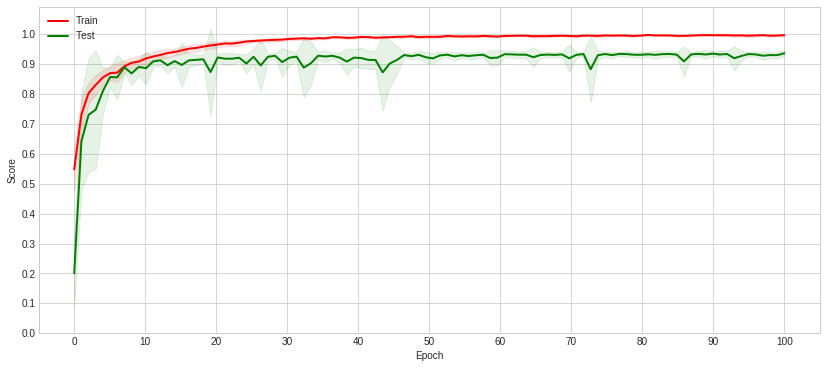

In [5]:
plot_mean_acc(hist)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

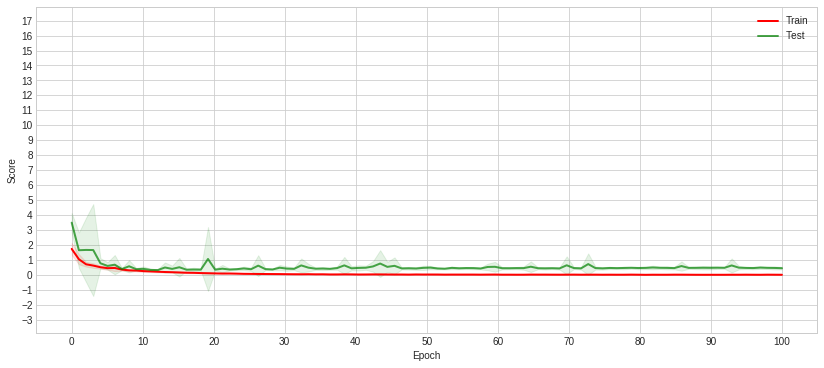

In [7]:
plot_mean_loss(hist)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

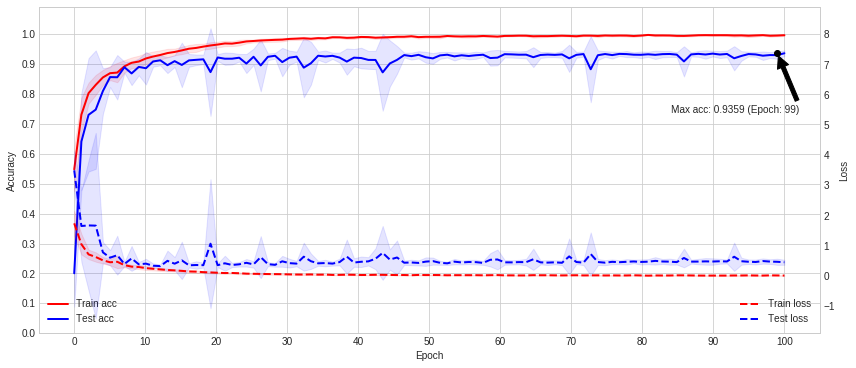

In [9]:
plot_mean(hist)